# Problem:

For this particular assignment, the data of different types of wine sales in the 20th century is to be analysed. Both of these data are from the same company but of different wines. As an analyst in the ABC Estate Wines, you are tasked to analyse and forecast Wine Sales in the 20th century.

In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from  statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima


## 1. Read the data as an appropriate Time Series data and plot the data.

**Importing data**

In [322]:
# reading the csv file into pandas dataframe

df_wine_sparkling = pd.read_csv('Sparkling.csv', parse_dates = ['YearMonth'], index_col = 'YearMonth')
display('Sparkling Wine', df_wine_sparkling.head() )

'Sparkling Wine'

Sparkling
YearMonth            
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471

In [323]:
display('Sparkling Wine', df_wine_sparkling.tail() )

'Sparkling Wine'

Sparkling
YearMonth            
1995-03-01       1897
1995-04-01       1862
1995-05-01       1670
1995-06-01       1688
1995-07-01       2031

In [324]:
df_wine_sparkling.shape[0]

(187, 1)

In [498]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 7

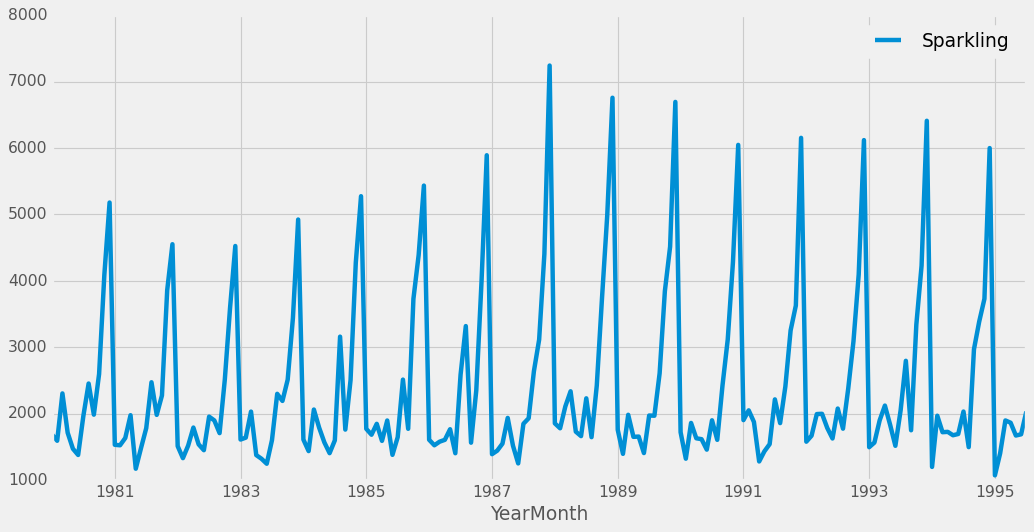

In [499]:
#Plot the time series

df_wine_sparkling.plot()
plt.show()
plt.style.use('fivethirtyeight')

**Insights**

•	Data values are stored in correct time order and no data is missing.

•	Intra-year stable fluctuations are indicative of seasonal component. 

•	There is an indication of multiplicative seasonality as Trend component is very minimal.

 

In [7]:
df_wine_sparkling.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sparkling  187 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


In [8]:
df_wine_sparkling.describe()

Sparkling
count   187.000000
mean   2402.417112
std    1295.111540
min    1070.000000
25%    1605.000000
50%    1874.000000
75%    2549.000000
max    7242.000000

## 2. Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.

In [9]:
# check for NULL values

df_wine_sparkling.isnull().sum()

Sparkling    0
dtype: int64

In [10]:
dups = df_wine_sparkling.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 11


### Year on Year Boxplot for Sparkling Wine production


Now, let us plot a box and whisker (1.5* IQR) plot to understand the spread of the data and check for outliers in each year, if any.

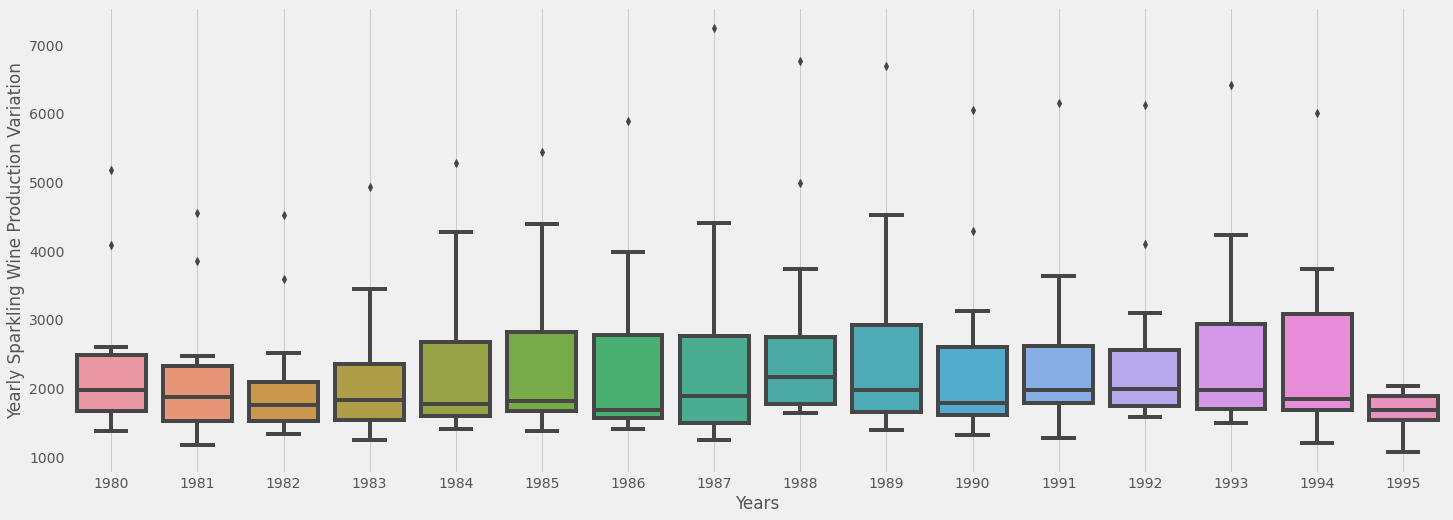

In [327]:
#whis :    Proportion of the IQR past the low and high quartiles to extend the
    # plot whiskers. Points outside this range will be identified as outliers.##
    

fig, ax = plt.subplots(figsize=(22,8))
sns.boxplot(df_wine_sparkling.index.year, df_wine_sparkling.Sparkling, ax=ax,whis=1.5)
plt.grid();
plt.xlabel('Years');
plt.ylabel('Yearly Sparkling Wine Production Variation');

**Insights**

 * We can see from the Time Series plot, the boxplots looks stationary (absence of Trend) 
 * Also, we see that the production of wine has some outliers for certain years.
 

### Monthly boxplot for the Sparkling Wine production 

Since this is a monthly data, let us plot a box and whisker (1.5* IQR) plot to understand the spread of the data and check for outliers for every month across all the years, if any.

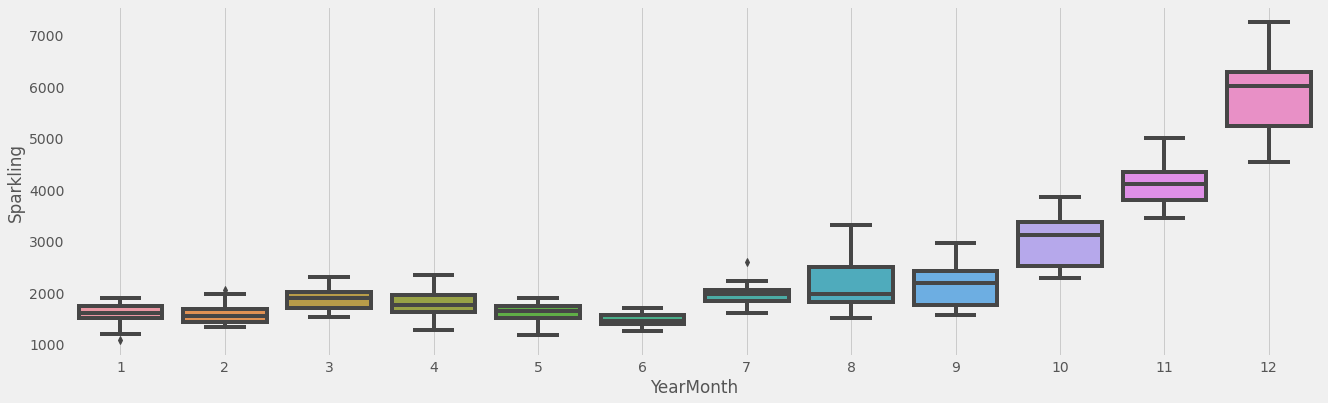

In [328]:
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(df_wine_sparkling.index.month, df_wine_sparkling.Sparkling, ax=ax,whis=1.5)
plt.grid();

**Insights**

 * The boxplots for the monthly production for different years has one outlier in the month of July.


## Seasonal Plot

In [334]:
yearly_sales_across_years

YearMonth    1980    1981    1982    1983    1984    1985    1986    1987  \
YearMonth                                                                   
January    1686.0  1530.0  1510.0  1609.0  1609.0  1771.0  1606.0  1389.0   
February   1591.0  1523.0  1329.0  1638.0  1435.0  1682.0  1523.0  1442.0   
March      2304.0  1633.0  1518.0  2030.0  2061.0  1846.0  1577.0  1548.0   
April      1712.0  1976.0  1790.0  1375.0  1789.0  1589.0  1605.0  1935.0   
May        1471.0  1170.0  1537.0  1320.0  1567.0  1896.0  1765.0  1518.0   
June       1377.0  1480.0  1449.0  1245.0  1404.0  1379.0  1403.0  1250.0   
July       1966.0  1781.0  1954.0  1600.0  1597.0  1645.0  2584.0  1847.0   
August     2453.0  2472.0  1897.0  2298.0  3159.0  2512.0  3318.0  1930.0   
September  1984.0  1981.0  1706.0  2191.0  1759.0  1771.0  1562.0  2638.0   
October    2596.0  2273.0  2514.0  2511.0  2504.0  3727.0  2349.0  3114.0   
November   4087.0  3857.0  3593.0  3440.0  4273.0  4388.0  3987.0  4405.0   
December   5179.0  4551.0  4524.0  4923.0  5274.0  5434.0  5891.0  7242.0   

YearMonth    1988    1989    1990    1991    1992    1993    1994    1995  
YearMonth                                                                  
January    1853.0  1757.0  1720.0  1902.0  1577.0  1494.0  1197.0  1070.0  
February   1779.0  1394.0  1321.0  2049.0  1667.0  1564.0  1968.0  1402.0  
March      2108.0  1982.0  1859.0  1874.0  1993.0  1898.0  1720.0  1897.0  
April      2336.0  1650.0  1628.0  1279.0  1997.0  2121.0  1725.0  1862.0  
May        1728.0  1654.0  1615.0  1432.0  1783.0  1831.0  1674.0  1670.0  
June       1661.0  1406.0  1457.0  1540.0  1625.0  1515.0  1693.0  1688.0  
July       2230.0  1971.0  1899.0  2214.0  2076.0  2048.0  2031.0  2031.0  
August     1645.0  1968.0  1605.0  1857.0  1773.0  2795.0  1495.0     NaN  
September  2421.0  2608.0  2424.0  2408.0  2377.0  1749.0  2968.0     NaN  
October    3740.0  3845.0  3116.0  3252.0  3088.0  3339.0  3385.0     NaN  
November   4988.0  4514.0  4286.0  3627.0  4096.0  4227.0  3729.0     NaN  
December   6757.0  6694.0  6047.0  6153.0  6119.0  6410.0  5999.0     NaN

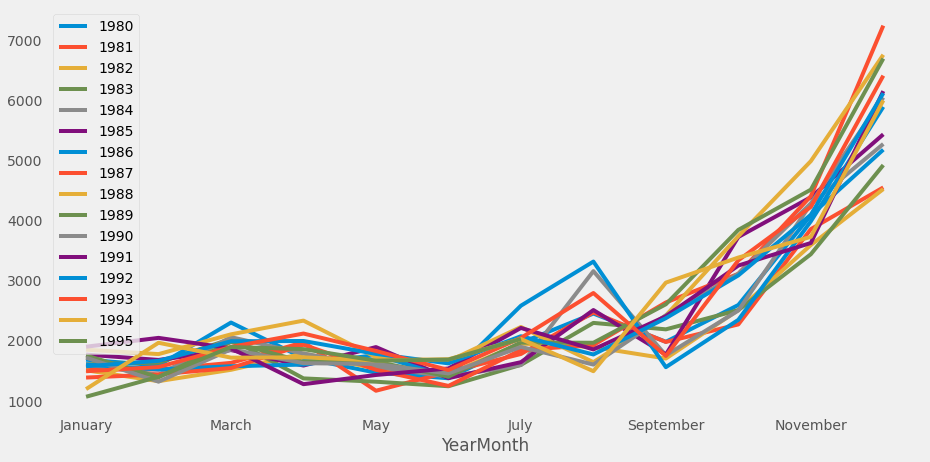

In [331]:
## Plot 1: Seasonal plot Year-wise 
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November', 'December']
yearly_sales_across_years = pd.pivot_table(df_wine_sparkling, values = 'Sparkling', columns = df_wine_sparkling.index.year,index = df_wine_sparkling.index.month_name())
yearly_sales_across_years = yearly_sales_across_years.reindex(index = months)
yearly_sales_across_years.plot()
plt.grid()
plt.legend(loc='best');

**Insights**

•	We can see that the Wine sales is seasonal. There is no increasing trend of sales.

•	There is an increasing sales in the month of November and December every year.


### Monthplot of the Sparkling Wine Time Series.

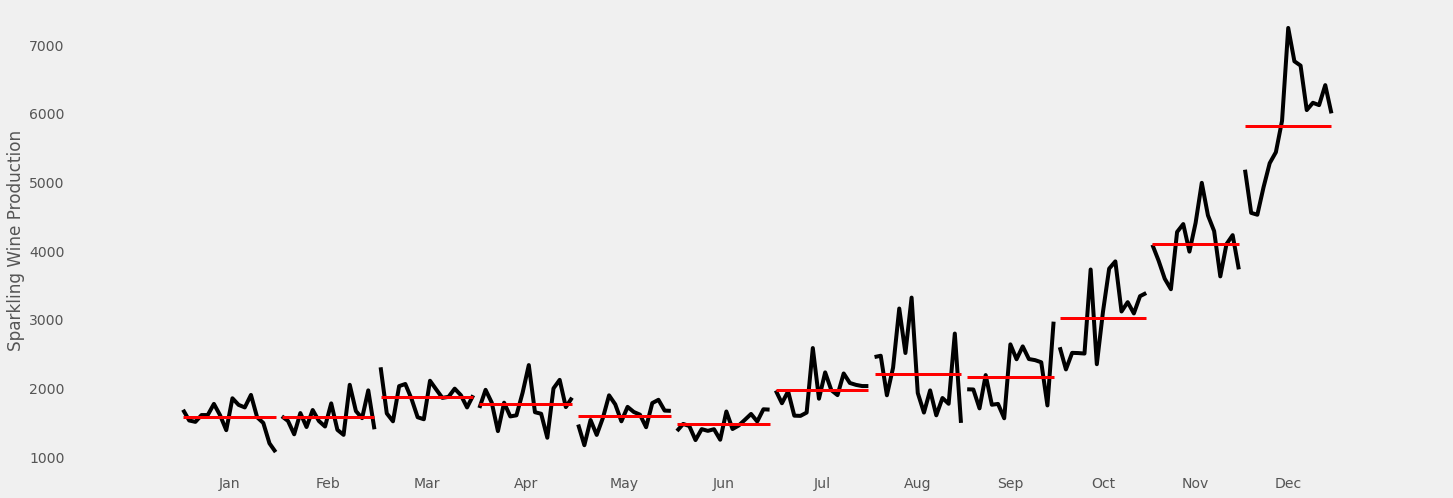

In [332]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize=(22,8))

month_plot(df_wine_sparkling,ylabel='Sparkling Wine Production',ax=ax)
plt.grid();

**Insights**

 * The "Red Line" indicates the Average production of Sparkling wine across 1980 to 1995. 
 * Sparkling wine has many fluctuations in every month.
 * We can see the increasing Trend in data every month.
 * In December, the production of wine increases. It can be because of Christmas & New Year.
 * The mean monthly production for June is lowest.

###  Time Series according to different months for different years of Sparkling Wine Production

In [15]:
yearly_sales_across_months_sparkling = pd.pivot_table(df_wine_sparkling, values = 'Sparkling', columns = df_wine_sparkling.index.month, 
                                        index = df_wine_sparkling.index.year)

yearly_sales_across_months_sparkling

YearMonth      1       2       3       4       5       6       7       8   \
YearMonth                                                                   
1980       1686.0  1591.0  2304.0  1712.0  1471.0  1377.0  1966.0  2453.0   
1981       1530.0  1523.0  1633.0  1976.0  1170.0  1480.0  1781.0  2472.0   
1982       1510.0  1329.0  1518.0  1790.0  1537.0  1449.0  1954.0  1897.0   
1983       1609.0  1638.0  2030.0  1375.0  1320.0  1245.0  1600.0  2298.0   
1984       1609.0  1435.0  2061.0  1789.0  1567.0  1404.0  1597.0  3159.0   
1985       1771.0  1682.0  1846.0  1589.0  1896.0  1379.0  1645.0  2512.0   
1986       1606.0  1523.0  1577.0  1605.0  1765.0  1403.0  2584.0  3318.0   
1987       1389.0  1442.0  1548.0  1935.0  1518.0  1250.0  1847.0  1930.0   
1988       1853.0  1779.0  2108.0  2336.0  1728.0  1661.0  2230.0  1645.0   
1989       1757.0  1394.0  1982.0  1650.0  1654.0  1406.0  1971.0  1968.0   
1990       1720.0  1321.0  1859.0  1628.0  1615.0  1457.0  1899.0  1605.0   
1991       1902.0  2049.0  1874.0  1279.0  1432.0  1540.0  2214.0  1857.0   
1992       1577.0  1667.0  1993.0  1997.0  1783.0  1625.0  2076.0  1773.0   
1993       1494.0  1564.0  1898.0  2121.0  1831.0  1515.0  2048.0  2795.0   
1994       1197.0  1968.0  1720.0  1725.0  1674.0  1693.0  2031.0  1495.0   
1995       1070.0  1402.0  1897.0  1862.0  1670.0  1688.0  2031.0     NaN   

YearMonth      9       10      11      12  
YearMonth                                  
1980       1984.0  2596.0  4087.0  5179.0  
1981       1981.0  2273.0  3857.0  4551.0  
1982       1706.0  2514.0  3593.0  4524.0  
1983       2191.0  2511.0  3440.0  4923.0  
1984       1759.0  2504.0  4273.0  5274.0  
1985       1771.0  3727.0  4388.0  5434.0  
1986       1562.0  2349.0  3987.0  5891.0  
1987       2638.0  3114.0  4405.0  7242.0  
1988       2421.0  3740.0  4988.0  6757.0  
1989       2608.0  3845.0  4514.0  6694.0  
1990       2424.0  3116.0  4286.0  6047.0  
1991       2408.0  3252.0  3627.0  6153.0  
1992       2377.0  3088.0  4096.0  6119.0  
1993       1749.0  3339.0  4227.0  6410.0  
1994       2968.0  3385.0  3729.0  5999.0  
1995          NaN     NaN     NaN     NaN

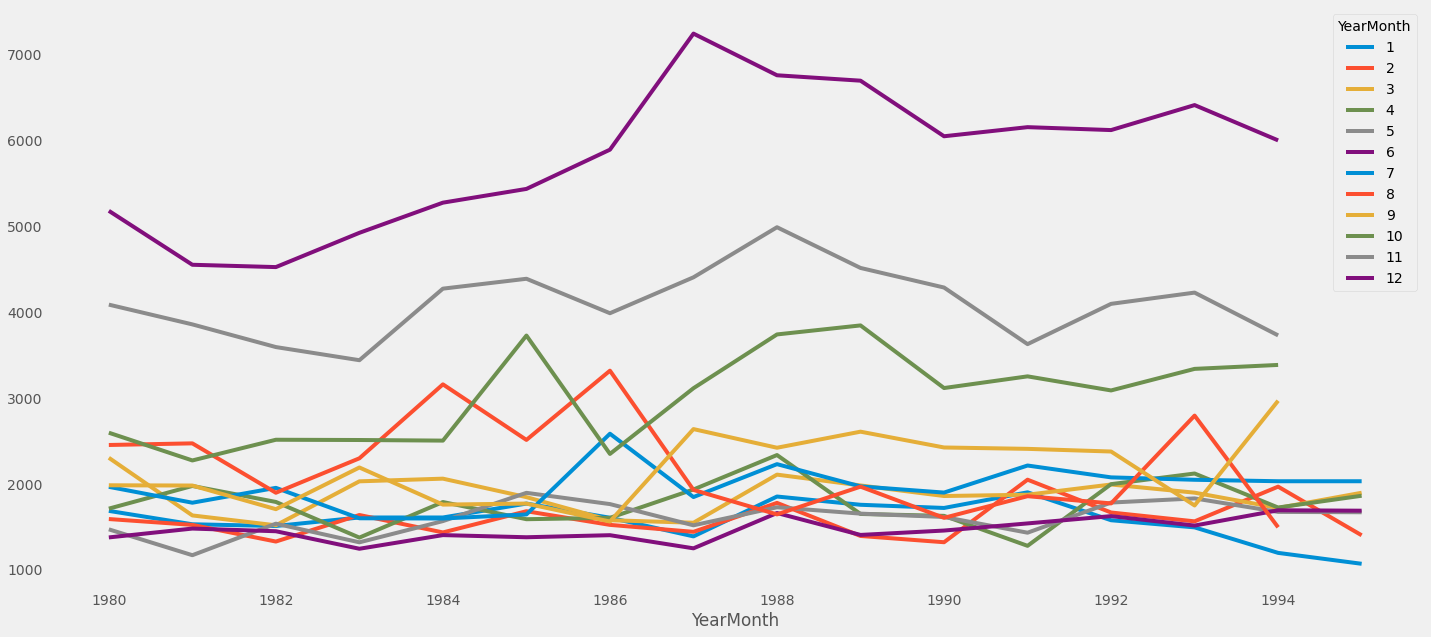

In [333]:
fig, ax = plt.subplots(figsize=(22,10))
yearly_sales_across_months_sparkling.plot(ax=ax)
plt.grid();

**Insights**

 * 	We can see that the Wine sales is above 5000 in the month of December every year.
 

### RESAMPLING - Monthly data of Sparkling Wine read into a quarterly, yearly, decadal, daily format


### Yearly Plot

The data is resampled or aggregated and the Time Series from an annual perspective is plotted with sum of the observations of each month.

In [17]:
df_yearly_sparkling = df_wine_sparkling.resample('A').sum()
df_yearly_sparkling.head()

Sparkling
YearMonth            
1980-12-31      28406
1981-12-31      26227
1982-12-31      25321
1983-12-31      26180
1984-12-31      28431

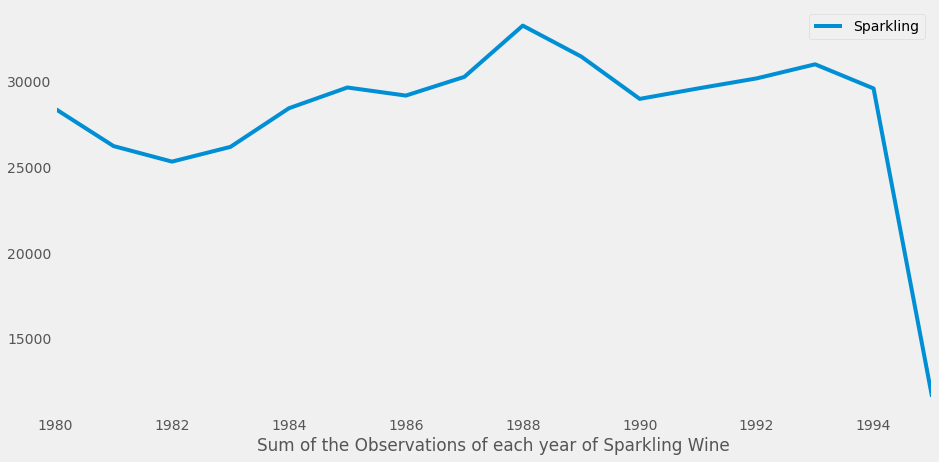

In [335]:
df_yearly_sparkling.plot();
plt.grid()
plt.xlabel('Sum of the Observations of each year of Sparkling Wine');

Let us try to resample or aggregate the Time Series from an annual perspective and take the mean of the observations of the year considering each month as an observation.

In [19]:
df_yearly_mean_sparkling = df_wine_sparkling.resample('Y').mean()
df_yearly_mean_sparkling.head()

Sparkling
YearMonth              
1980-12-31  2367.166667
1981-12-31  2185.583333
1982-12-31  2110.083333
1983-12-31  2181.666667
1984-12-31  2369.250000

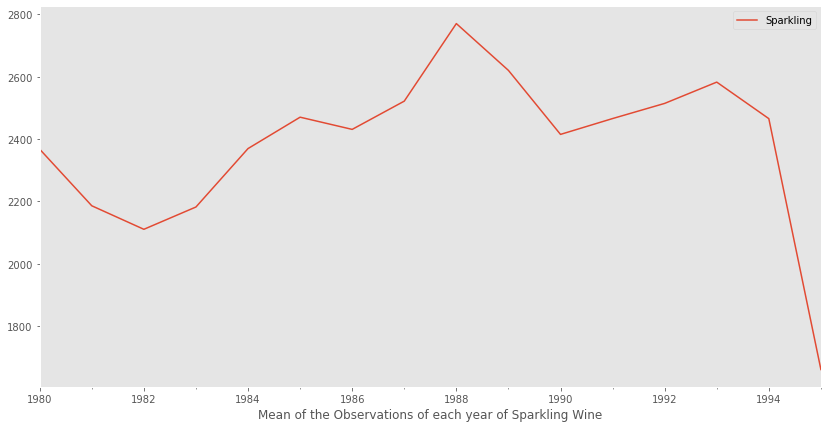

In [20]:
df_yearly_mean_sparkling.plot();
plt.grid()
plt.xlabel('Mean of the Observations of each year of Sparkling Wine');

•	The resampled yearly or annual series have smoothened out the seasonality and have only been able to capture the year on year trend .
•	We can see that Yearly sales of wine has decreasing trend post 1994.


### Quarterly Plot

The data is resampled or aggregated and the Time Series from an quartely perspective and its is plotted with sum of the observations of every three months.

In [21]:
df_quarterly_sum_sparkling = df_wine_sparkling.resample('Q').sum()
df_quarterly_sum_sparkling.head()

Sparkling
YearMonth            
1980-03-31       5581
1980-06-30       4560
1980-09-30       6403
1980-12-31      11862
1981-03-31       4686

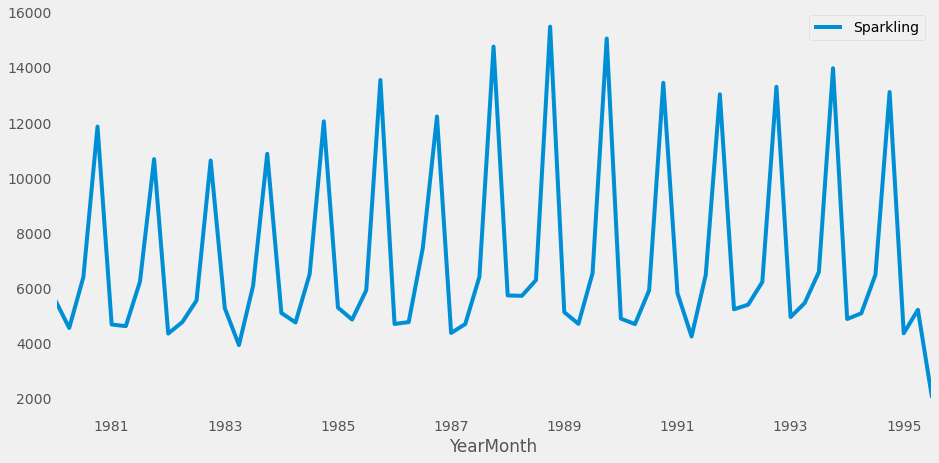

In [336]:
df_quarterly_sum_sparkling.plot();
plt.grid()

•	We can see that Quarterly sales of the wine has decreasing trend post 1995.

•	IT has seasonal Fluctutations.


In [23]:
df_quarterly_mean_sparkling = df_wine_sparkling.resample('Q').mean()
df_quarterly_mean_sparkling.head()

Sparkling
YearMonth              
1980-03-31  1860.333333
1980-06-30  1520.000000
1980-09-30  2134.333333
1980-12-31  3954.000000
1981-03-31  1562.000000

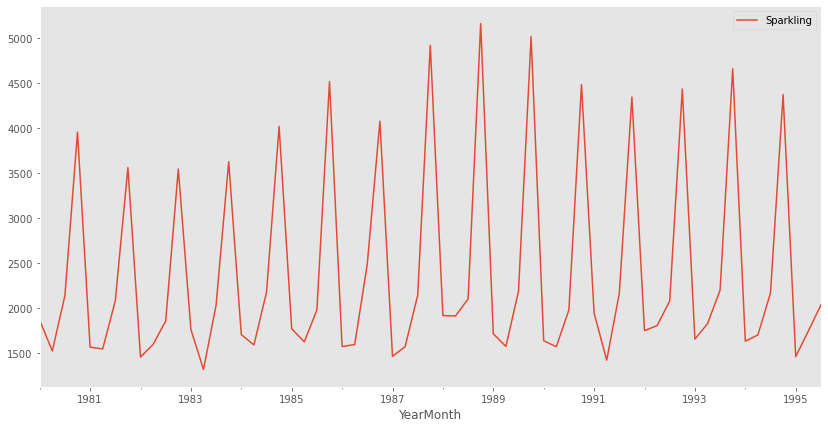

In [24]:
df_quarterly_mean_sparkling.plot();
plt.grid()

We see that the year on year quarterly series represents the year on year monthly series. The quarterly series is able to catch the seasonality in the data.

### Decade Plot

In [25]:
df_decade_sum_sparkling = df_wine_sparkling.resample('10Y').sum()
df_decade_sum_sparkling

Sparkling
YearMonth            
1980-12-31      28406
1990-12-31     288893
2000-12-31     131953

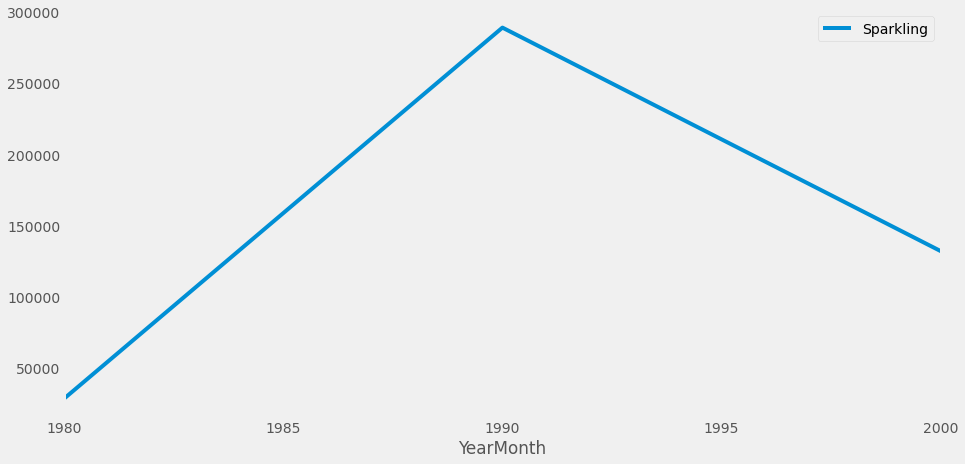

In [337]:
df_decade_sum_sparkling.plot();
plt.grid()

If we take the resampling period to be 10 years or a decade, we see that the seasonality present has been smoothed over and it is only giving an estimate of the trend

### Daily Plot

In [27]:
df_daily_sum_sparkling = df_wine_sparkling.resample('D').sum()
df_daily_sum_sparkling

Sparkling
YearMonth            
1980-01-01       1686
1980-01-02          0
1980-01-03          0
1980-01-04          0
1980-01-05          0
...               ...
1995-06-27          0
1995-06-28          0
1995-06-29          0
1995-06-30          0
1995-07-01       2031

[5661 rows x 1 columns]

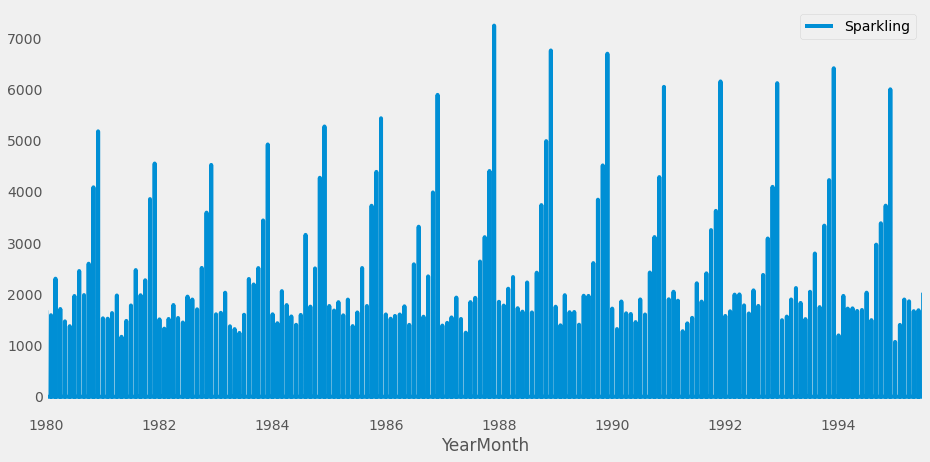

In [338]:
df_daily_sum_sparkling.plot()
plt.grid();

The above graph fails to give us a proper understanding of our data. Thus, resampling the data to intervals where a number of observations are 0 is not a good idea as that does not give us an understanding of the performance of the time series.

To get a very high-level overview of the trend of the Time Series Data (if Trend is present) can be understood by resampling the data keeping the intervals very large.

## Decomposing the Sparkling Wine Time Series

### Additive Model

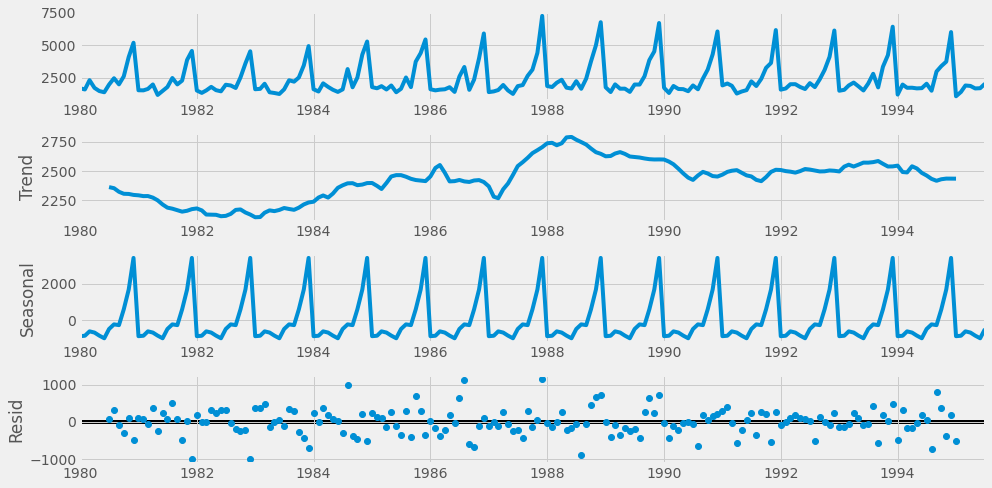

In [339]:
decomposition = seasonal_decompose(df_wine_sparkling,model='additive')
decomposition.plot();

As per the 'additive' decomposition, we see that there is a pronounced trend in the earlier years of the data. There is a seasonality as well.

In [30]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

In [31]:
print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 YearMonth
1980-01-01            NaN
1980-02-01            NaN
1980-03-01            NaN
1980-04-01            NaN
1980-05-01            NaN
1980-06-01            NaN
1980-07-01    2360.666667
1980-08-01    2351.333333
1980-09-01    2320.541667
1980-10-01    2303.583333
1980-11-01    2302.041667
1980-12-01    2293.791667
Name: trend, dtype: float64 

Seasonality 
 YearMonth
1980-01-01    -854.260599
1980-02-01    -830.350678
1980-03-01    -592.356630
1980-04-01    -658.490559
1980-05-01    -824.416154
1980-06-01    -967.434011
1980-07-01    -465.502265
1980-08-01    -214.332821
1980-09-01    -254.677265
1980-10-01     599.769957
1980-11-01    1675.067179
1980-12-01    3386.983846
Name: seasonal, dtype: float64 

Residual 
 YearMonth
1980-01-01           NaN
1980-02-01           NaN
1980-03-01           NaN
1980-04-01           NaN
1980-05-01           NaN
1980-06-01           NaN
1980-07-01     70.835599
1980-08-01    315.999487
1980-09-01    -81.864401
1980-10-01   -307.353290


In [340]:
deaseasonalized_ts = trend + residual
deaseasonalized_ts.head(12)

YearMonth
1980-01-01            NaN
1980-02-01            NaN
1980-03-01            NaN
1980-04-01            NaN
1980-05-01            NaN
1980-06-01            NaN
1980-07-01    2361.695896
1980-08-01    2352.468741
1980-09-01    2321.497620
1980-10-01    2304.490847
1980-11-01    2303.092089
1980-12-01    2294.738436
dtype: float64

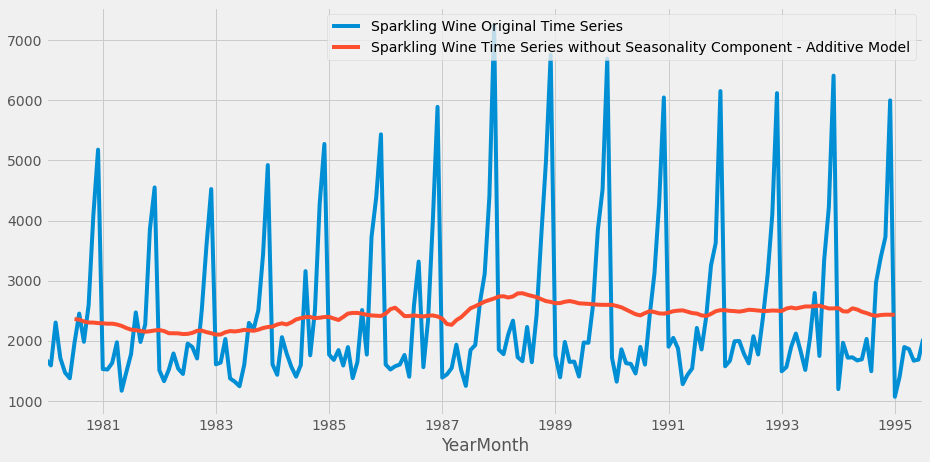

In [341]:
df_wine_sparkling.plot()
deaseasonalized_ts.plot()
plt.legend(["Sparkling Wine Original Time Series", "Sparkling Wine Time Series without Seasonality Component - Additive Model"]);

We can observe that this Time series data without seasonality gives a straight line.

### Multiplicative Model

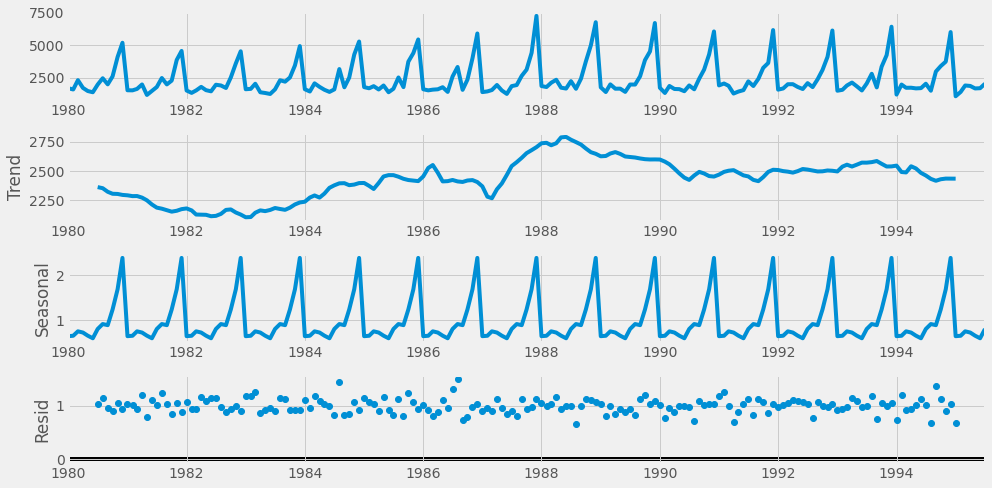

In [342]:
decomposition = seasonal_decompose(df_wine_sparkling,model='mltiplicative')
decomposition.plot();

In [35]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 YearMonth
1980-01-01            NaN
1980-02-01            NaN
1980-03-01            NaN
1980-04-01            NaN
1980-05-01            NaN
1980-06-01            NaN
1980-07-01    2360.666667
1980-08-01    2351.333333
1980-09-01    2320.541667
1980-10-01    2303.583333
1980-11-01    2302.041667
1980-12-01    2293.791667
Name: trend, dtype: float64 

Seasonality 
 YearMonth
1980-01-01    0.649843
1980-02-01    0.659214
1980-03-01    0.757440
1980-04-01    0.730351
1980-05-01    0.660609
1980-06-01    0.603468
1980-07-01    0.809164
1980-08-01    0.918822
1980-09-01    0.894367
1980-10-01    1.241789
1980-11-01    1.690158
1980-12-01    2.384776
Name: seasonal, dtype: float64 

Residual 
 YearMonth
1980-01-01         NaN
1980-02-01         NaN
1980-03-01         NaN
1980-04-01         NaN
1980-05-01         NaN
1980-06-01         NaN
1980-07-01    1.029230
1980-08-01    1.135407
1980-09-01    0.955954
1980-10-01    0.907513
1980-11-01    1.050423
1980-12-01    0.946770
Name: resi

In [36]:
deaseasonalized_ts = trend + residual
deaseasonalized_ts.head(12)

YearMonth
1980-01-01            NaN
1980-02-01            NaN
1980-03-01            NaN
1980-04-01            NaN
1980-05-01            NaN
1980-06-01            NaN
1980-07-01    2361.695896
1980-08-01    2352.468741
1980-09-01    2321.497620
1980-10-01    2304.490847
1980-11-01    2303.092089
1980-12-01    2294.738436
dtype: float64

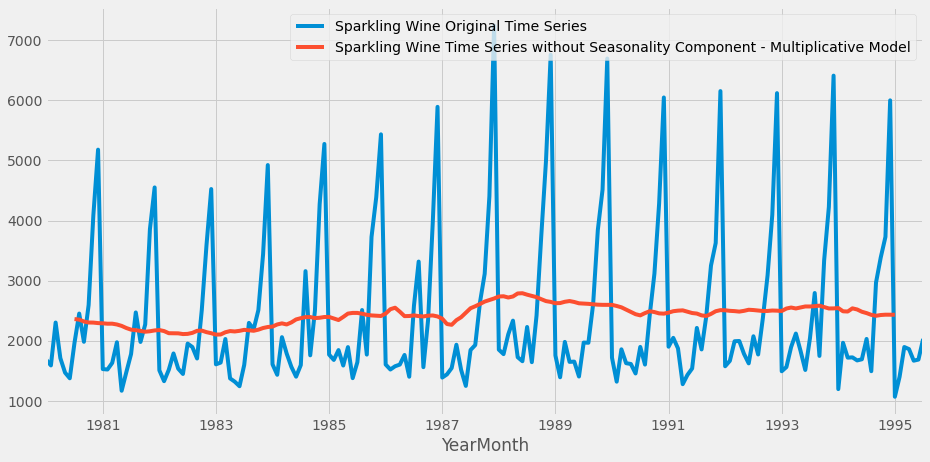

In [343]:
df_wine_sparkling.plot()
deaseasonalized_ts.plot()
plt.legend(["Sparkling Wine Original Time Series", "Sparkling Wine Time Series without Seasonality Component - Multiplicative Model"]);

**Insights**

 * We can observe that this Time series data without seasonality gives a straight line.

## Empirical Cumulative Distribution - Sparkling Wine

In [350]:
import plotly.express as px

plt.figure(figsize = (18, 8))
fig = px.ecdf(df_wine_sparkling, x="Sparkling");
fig.show();

<Figure size 1296x576 with 0 Axes>

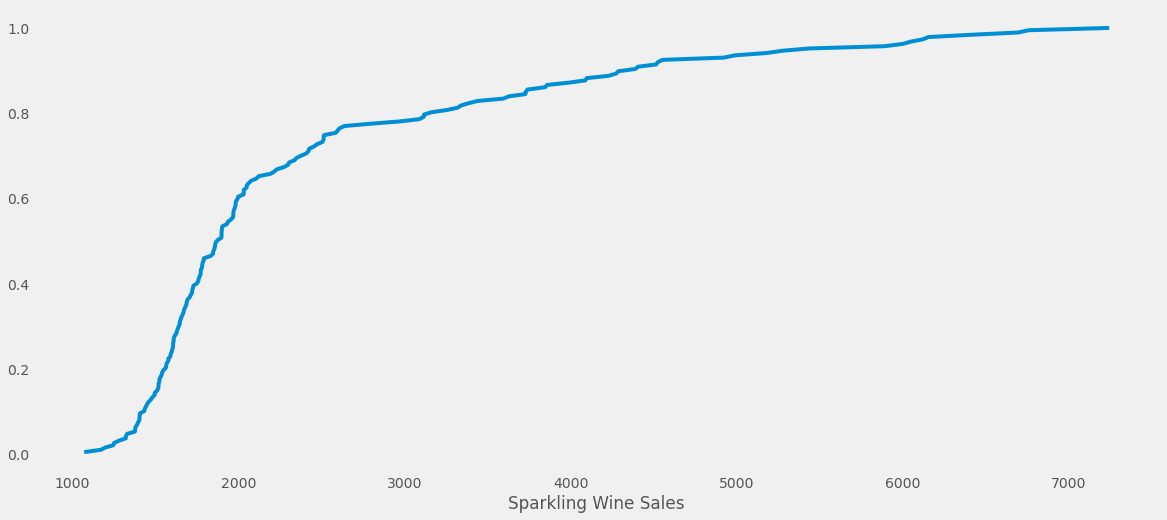

In [345]:
# statistics
from statsmodels.distributions.empirical_distribution import ECDF

plt.figure(figsize = (18, 8))
cdf = ECDF(df_wine_sparkling['Sparkling'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.grid()
plt.xlabel('Sparkling Wine Sales');

This particular graph tells us what percentage of data points refer to what number of Sales.

## Average Sparkling Wine Sales per month and the month on month percentage change of Wine sales

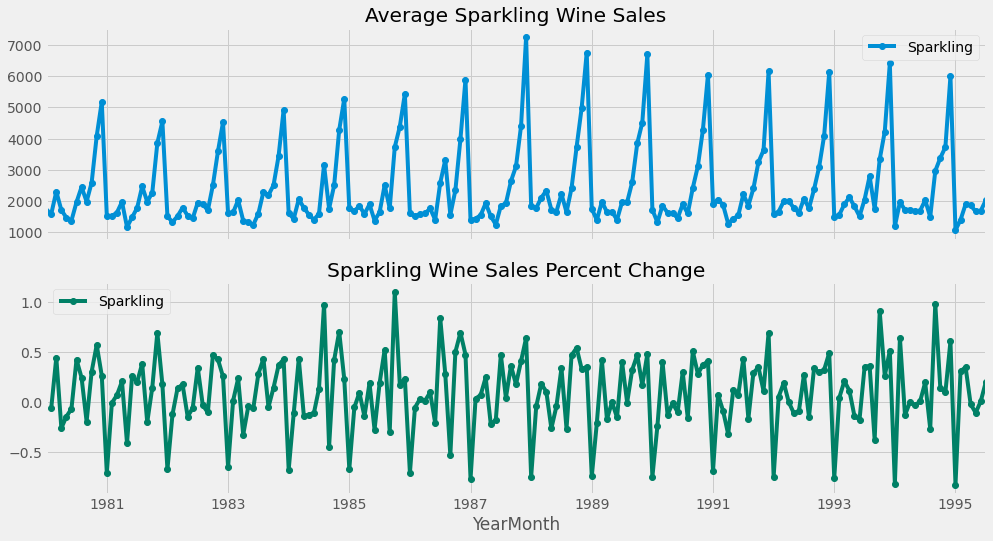

In [351]:
# group by date and get average RetailSales, and precent change
average    = df_wine_sparkling.groupby(df_wine_sparkling.index)["Sparkling"].mean()
pct_change = df_wine_sparkling.groupby(df_wine_sparkling.index)["Sparkling"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average RetailSales over time(year-month)
ax1 = average.plot(legend=True,ax=axis1,marker='o',title="Average Sparkling Wine Sales",grid=True)
ax1.set_xticks(range(len(average)))
ax1.set_xticklabels(average.index.tolist())
# plot precent change for RetailSales over time(year-month)
ax2 = pct_change.plot(legend=True,ax=axis2,marker='o',colormap="summer",title="Sparkling Wine Sales Percent Change",grid=True)

The above two graphs tells us the Average 'Sparkling Wine Sales' and the Percentage change of 'Sparkling Wine Sales' with respect to the time.

## 3. Split the data into training and test. The test data should start in 1991.

**Training Data is till the end of 1990. Test Data is from the beginning of 1991 to the last time stamp provided.**

### Sparkling Wine

In [40]:
train_sparkling=df_wine_sparkling[df_wine_sparkling.index.year < 1991]
test_sparkling=df_wine_sparkling[df_wine_sparkling.index.year >= 1991]

In [41]:
display("Train data shape of Sparkling wine ",train_sparkling.shape)
display("Test data shape of Sparkling wine ",test_sparkling.shape)

'Train data shape of Sparkling wine '

(132, 1)

'Test data shape of Sparkling wine '

(55, 1)

In [42]:
print('First few rows of Sparkling Wine Train Data')
display(train_sparkling.head())
print('Last few rows of Sparkling Wine Train Data')
display(train_sparkling.tail())
print('First few rows of Sparkling Wine Test Data')
display(test_sparkling.head())
print('Last few rows of Sparkling Wine Test Data')
display(test_sparkling.tail())

First few rows of Sparkling Wine Train Data


Sparkling
YearMonth            
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471

Last few rows of Sparkling Wine Train Data


Sparkling
YearMonth            
1990-08-01       1605
1990-09-01       2424
1990-10-01       3116
1990-11-01       4286
1990-12-01       6047

First few rows of Sparkling Wine Test Data


Sparkling
YearMonth            
1991-01-01       1902
1991-02-01       2049
1991-03-01       1874
1991-04-01       1279
1991-05-01       1432

Last few rows of Sparkling Wine Test Data


Sparkling
YearMonth            
1995-03-01       1897
1995-04-01       1862
1995-05-01       1670
1995-06-01       1688
1995-07-01       2031

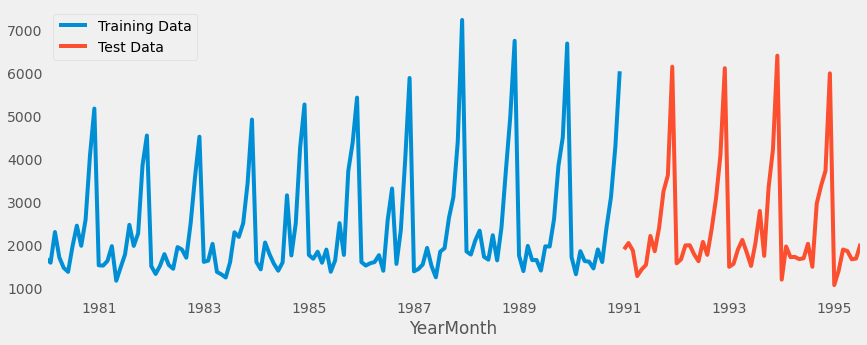

In [352]:
train_sparkling['Sparkling'].plot(figsize=(13,5), fontsize=14)
test_sparkling['Sparkling'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

From our train-test split we are predicting likewise behaviour as compared to the past years.

## 4. Build all the exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other models such as regression,naïve forecast models and simple average models. should also be built on the training data and check the performance on the test data using RMSE.

### Simple Exponential Smoothing Model


### Sparkling Wine data


In [48]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [49]:
SES_train_sparkling = train_sparkling.copy()
SES_test_sparkling = test_sparkling.copy()

In [50]:
model_SES_sparkling = SimpleExpSmoothing(SES_train_sparkling['Sparkling'])
model_SES_autofit_sparkling = model_SES_sparkling.fit()
model_SES_autofit_sparkling.params

{'smoothing_level': 0.049607360581862936,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1818.535750008871,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [52]:
SES_test_sparkling['predict'] = model_SES_autofit_sparkling.forecast(steps=len(test_sparkling))
SES_test_sparkling.head()

Sparkling      predict
YearMonth                         
1991-01-01       1902  2724.932624
1991-02-01       2049  2724.932624
1991-03-01       1874  2724.932624
1991-04-01       1279  2724.932624
1991-05-01       1432  2724.932624

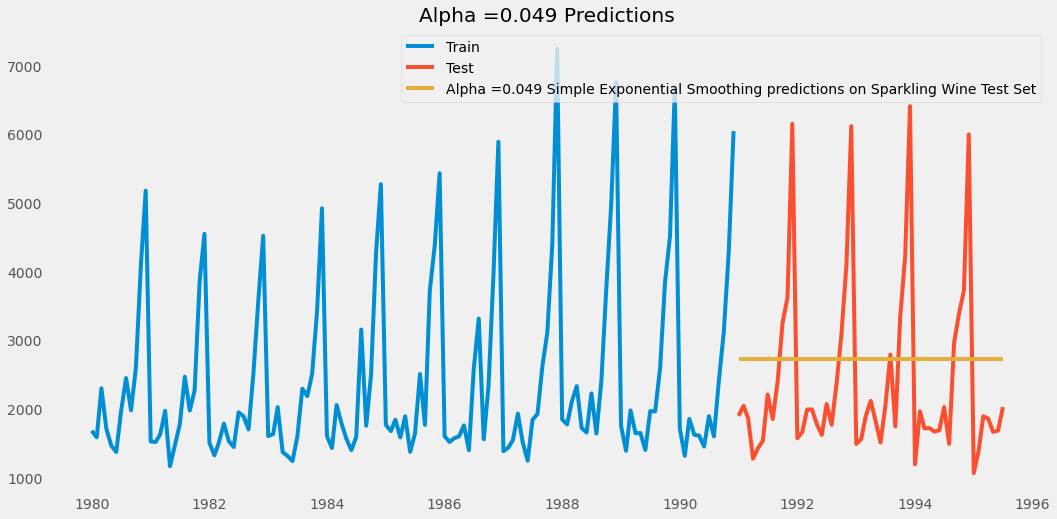

In [353]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(SES_train_sparkling['Sparkling'], label='Train')
plt.plot(SES_test_sparkling['Sparkling'], label='Test')

plt.plot(SES_test_sparkling['predict'], label='Alpha =0.049 Simple Exponential Smoothing predictions on Sparkling Wine Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha =0.049 Predictions');

### Model Evaluation for 𝛼 = 0.049 : Simple Exponential Smoothing

In [54]:
## Test Data
from sklearn import metrics
rmse_ses_sparkling = metrics.mean_squared_error(SES_test_sparkling['Sparkling'],SES_test_sparkling['predict'],squared=False)
print("For Alpha =0.049 Simple Exponential Smoothing Model forecast on the Sparkling Wine Test Data, RMSE is %3.3f" %(rmse_ses_sparkling))


For Alpha =0.049 Simple Exponential Smoothing Model forecast on the Sparkling Wine Test Data, RMSE is 1316.035


In [485]:
results = pd.DataFrame({'Test RMSE': [rmse_ses_sparkling]},index=['Alpha=0.049,SimpleExponentialSmoothing-Sparkling Wine'])
results

Test RMSE
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...  1316.035487

**Setting different alpha values:**

The higher the alpha value more weightage is given to the more recent observation. That means, what happened recently will happen again.

We will run a loop with different alpha values to understand which particular value works best for alpha on the test set.

In [56]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_6 = pd.DataFrame({'Alpha Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_6

Empty DataFrame
Columns: [Alpha Values, Train RMSE, Test RMSE]
Index: []

In [58]:
alpha_list = [0.3,0.4,0.5,0.6,0.7,0.8,0.9] 

In [59]:
from statsmodels.tools.eval_measures import rmse 

for i in alpha_list:
    model_SES_alpha_i = model_SES_sparkling.fit(smoothing_level=i)
    
    SES_train_sparkling['predict',i] = model_SES_alpha_i.fittedvalues.round(0)
    SES_test_sparkling['predict',i] = model_SES_alpha_i.forecast(steps=len(test_sparkling)).round(0)
    
    rmse_model5_train_i = metrics.mean_squared_error(SES_train_sparkling['Sparkling'],SES_train_sparkling['predict',i],squared=False)
    
    rmse_model5_test_i = metrics.mean_squared_error(SES_test_sparkling['Sparkling'],SES_test_sparkling['predict',i],squared=False)
    
    resultsDf_6 = resultsDf_6.append({'Alpha Values':i,
                                      'Train RMSE': rmse_model5_train_i,
                                      'Test RMSE':rmse_model5_test_i}, 
                                     ignore_index=True)

In [60]:
SES_test_sparkling.head()

Sparkling      predict  (predict, 0.3)  (predict, 0.4)  \
YearMonth                                                            
1991-01-01       1902  2724.932624          3855.0          4328.0   
1991-02-01       2049  2724.932624          3855.0          4328.0   
1991-03-01       1874  2724.932624          3855.0          4328.0   
1991-04-01       1279  2724.932624          3855.0          4328.0   
1991-05-01       1432  2724.932624          3855.0          4328.0   

            (predict, 0.5)  (predict, 0.6)  (predict, 0.7)  (predict, 0.8)  \
YearMonth                                                                    
1991-01-01          4741.0          5092.0          5389.0          5641.0   
1991-02-01          4741.0          5092.0          5389.0          5641.0   
1991-03-01          4741.0          5092.0          5389.0          5641.0   
1991-04-01          4741.0          5092.0          5389.0          5641.0   
1991-05-01          4741.0          5092.0          5389.0          5641.0   

            (predict, 0.9)  
YearMonth                   
1991-01-01          5858.0  
1991-02-01          5858.0  
1991-03-01          5858.0  
1991-04-01          5858.0  
1991-05-01          5858.0

**Model Evaluation**

In [61]:
resultsDf_6.sort_values(by=['Test RMSE'],ascending=True)

Alpha Values   Train RMSE    Test RMSE
0           0.3  1359.416182  1935.284109
1           0.4  1352.559157  2312.205004
2           0.5  1343.969175  2666.476108
3           0.6  1338.779719  2979.476083
4           0.7  1338.895834  3250.391104
5           0.8  1344.508596  3483.594841
6           0.9  1355.752019  3686.392124

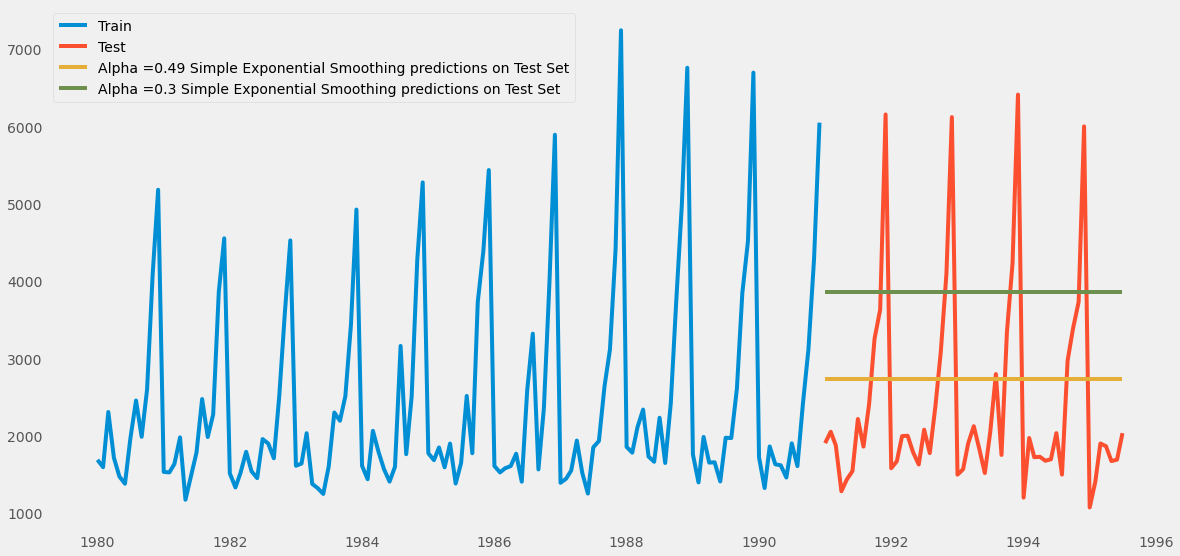

In [355]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(SES_train_sparkling['Sparkling'], label='Train')
plt.plot(SES_test_sparkling['Sparkling'], label='Test')

plt.plot(SES_test_sparkling['predict'], label='Alpha =0.49 Simple Exponential Smoothing predictions on Test Set')

plt.plot(SES_test_sparkling['predict', 0.3], label='Alpha =0.3 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid();

In [486]:
resultsDf_6_1 = pd.DataFrame({'Test RMSE': [resultsDf_6.sort_values(by=['Test RMSE'], ascending=True).values[0][2]]}, 
                             index = ['Alpha=0.3,SimpleExponentialSmoothing - Sparkling Wine'])

results = pd.concat([results, resultsDf_6_1])
results

Test RMSE
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...  1316.035487
Alpha=0.3,SimpleExponentialSmoothing - Sparklin...  1935.284109

**Inference**

* We can see that at Alpha = 0.049, the Single Exponential Smoothing (SES) works better than at Alpha = 0.3.



### Double Exponential Smoothing (Holt's Model)


Two parameters 𝛼 and 𝛽 are estimated in this model. Level and Trend are accounted for in this model.

### Sparkling Wine Data

In [357]:
# Initializing the Double Exponential Smoothing Model
model_DES_init = Holt(train_sparkling,initialization_method='estimated')
# Fitting the model
model_DES_init = model_DES_init.fit()

print('')
print('==Holt model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_DES_init.params)


==Holt model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.6649999999999999, 'smoothing_trend': 0.0001, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 1502.1999999999991, 'initial_trend': 74.87272727272739, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [359]:
# Forecasting using this model for the duration of the test set
DES_predict_init =  model_DES_init.forecast(len(test_sparkling))

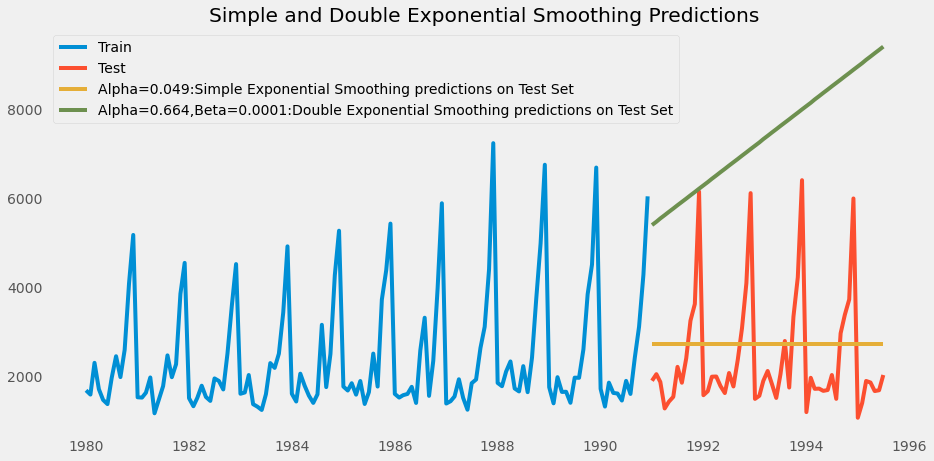

In [360]:
## Plotting the Training data, Test data and the forecasted values

plt.plot(train_sparkling, label='Train')
plt.plot(test_sparkling, label='Test')

plt.plot(SES_test_sparkling['predict'], label='Alpha=0.049:Simple Exponential Smoothing predictions on Test Set')
plt.plot(DES_predict_init, label='Alpha=0.664,Beta=0.0001:Double Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Simple and Double Exponential Smoothing Predictions');

We see that the double exponential smoothing is picking up the trend component along with the level component as well.

In [487]:
rmse_des_init = rmse(test_sparkling['Sparkling'],DES_predict_init.values)
print('DES RMSE at Alpha = 0.664, Beta=0.0001 :',rmse_des_init)

DES RMSE at Alpha = 0.664, Beta=0.0001 : 5291.8798332269125


**Inference**

Here, we see that the Double Exponential Smoothing has actually not performed well when compared to the Simple Exponential Smoothing. This is because of the fact that the Double Exponential Smoothing model has picked up the trend component.


In [488]:
results_des_init = pd.DataFrame({'Test RMSE': rmse_des_init }, 
                             index = ['Alpha = 0.664, Beta=0.0001,SimpleExponentialSmoothing - Sparkling Wine'])

results = pd.concat([results, results_des_init])
results

Test RMSE
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...  1316.035487
Alpha=0.3,SimpleExponentialSmoothing - Sparklin...  1935.284109
Alpha = 0.664, Beta=0.0001,SimpleExponentialSmo...  5291.879833

### Identifying Optimum Values of 𝛼 & 𝛽

In [64]:
DES_train_sparkling = train_sparkling.copy()
DES_test_sparkling = test_sparkling.copy()
model_DES_sparkling = Holt(DES_train_sparkling['Sparkling'])

In [65]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_7 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_7

Empty DataFrame
Columns: [Alpha Values, Beta Values, Train RMSE, Test RMSE]
Index: []

In [479]:
alpha_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
beta_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [480]:
for i in alpha_list:
    for j in beta_list:
        model_DES_alpha_i_j = model_DES_sparkling.fit(smoothing_level=i,smoothing_trend=j)
        
        DES_train_sparkling['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test_sparkling['predict',i,j] = model_DES_alpha_i_j.forecast(steps=len(test_sparkling))
        
        rmse_model6_train =  rmse(DES_train_sparkling['Sparkling'],DES_train_sparkling['predict',i,j])#,squared=False)
        
        rmse_model6_test =  rmse(DES_test_sparkling['Sparkling'],DES_test_sparkling['predict',i,j])#,squared=False)
        
        resultsDf_7 = resultsDf_7.append({'Alpha Values':i,
                                          'Beta Values':j,
                                          'Train RMSE': rmse_model6_train,
                                          'Test RMSE': rmse_model6_test}, ignore_index=True)

In [481]:
resultsDf_7.sort_values(by=['Test RMSE']).head()

Alpha Values  Beta Values   Train RMSE    Test RMSE
68           0.0          0.4  1279.322346  1389.129175
66           0.0          0.2  1279.322346  1389.131783
65           0.0          0.1  1279.322346  1389.131783
74           0.0          1.0  1279.322346  1389.134240
67           0.0          0.3  1279.322346  1389.134637

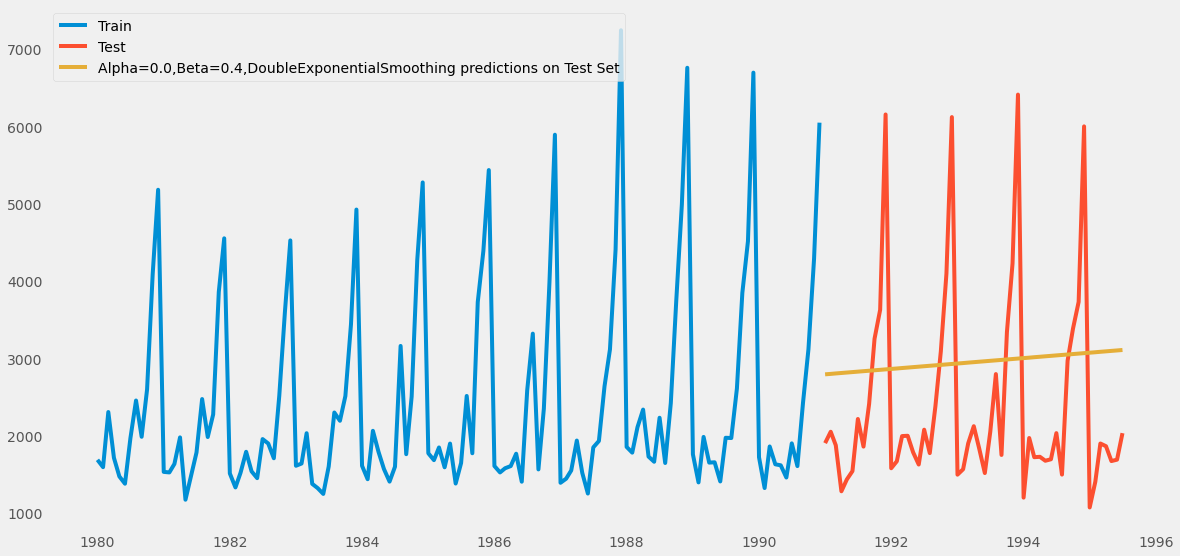

In [482]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(DES_train_sparkling['Sparkling'], label='Train')
plt.plot(DES_test_sparkling['Sparkling'], label='Test')

plt.plot(DES_test_sparkling['predict', 0.0, 0.4],
         label='Alpha=0.0,Beta=0.4,DoubleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [483]:
rmse_des_init_1 = resultsDf_7.sort_values(by=['Test RMSE']).values[0][3]
print('DES RMSE at Alpha = 0.0, Beta=0.4 :',rmse_des_init_1)

DES RMSE at Alpha = 0.0, Beta=0.4 : 1389.1291754728525


In [489]:
resultsDf_7_1 = pd.DataFrame({'Test RMSE': [resultsDf_7.sort_values(by=['Test RMSE']).values[0][3]]}
                           ,index=['Alpha=0.0,Beta=0.4,DoubleExponentialSmoothing-Sparkling Wine'])

results = pd.concat([results, resultsDf_7_1])
results



Test RMSE
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...  1316.035487
Alpha=0.3,SimpleExponentialSmoothing - Sparklin...  1935.284109
Alpha = 0.664, Beta=0.0001,SimpleExponentialSmo...  5291.879833
Alpha=0.0,Beta=0.4,DoubleExponentialSmoothing-S...  1389.129175

## Triple Exponential Smoothing - Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

### Sparkling Wine Data

In [73]:
TES_train_sparkling = train_sparkling.copy()
TES_test_sparkling = test_sparkling.copy()

In [376]:
# Initializing the Double Exponential Smoothing Model
model_TES_sparkling = ExponentialSmoothing(train_sparkling,trend='additive',seasonal='additive',initialization_method='estimated')
# Fitting the model
model_TES_sparkling = model_TES_sparkling.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_TES_sparkling.params)


==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.11127227248079453, 'smoothing_trend': 0.012360804305088534, 'smoothing_seasonal': 0.46071766688111543, 'damping_trend': nan, 'initial_level': 2356.577980956387, 'initial_trend': -0.10243675533021725, 'initial_seasons': array([-636.23319334, -722.9832009 , -398.64410813, -473.43045416,
       -808.42473284, -815.34991402, -384.23065038,   72.99484403,
       -237.44226045,  272.32608272, 1541.37737052, 2590.07692296]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [75]:
TES_test_sparkling['auto_predict'] = model_TES_sparkling.forecast(steps=len(test_sparkling)).round(0)

TES_test_sparkling.head()

Sparkling  auto_predict
YearMonth                          
1991-01-01       1902        1490.0
1991-02-01       2049        1205.0
1991-03-01       1874        1689.0
1991-04-01       1279        1551.0
1991-05-01       1432        1461.0

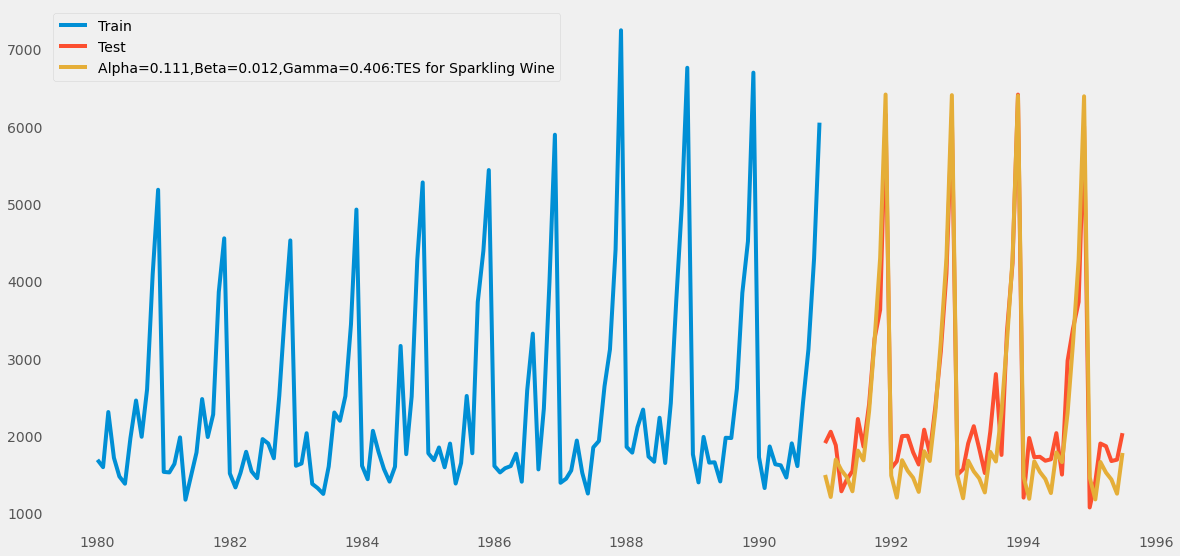

In [374]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(train_sparkling['Sparkling'], label='Train')
plt.plot(test_sparkling['Sparkling'], label='Test')

plt.plot(TES_test_sparkling['auto_predict'], label='Alpha=0.111,Beta=0.012,Gamma=0.406:TES for Sparkling Wine')


plt.legend(loc='best')
plt.grid();

In [375]:
## Test Data

rmse_model6_test_1 = rmse(TES_test_sparkling['Sparkling'],
                          TES_test_sparkling['auto_predict'])
print("The RMSE value at Alpha=0.111,Beta=0.012,Gamma=0.406,TES Model is :",rmse_model6_test_1)

The RMSE value at Alpha=0.111,Beta=0.012,Gamma=0.406,TES Model is : 378.8972036174072


In [490]:
resultsDf_8_1 = pd.DataFrame({'Test RMSE': [rmse_model6_test_1]}
                           ,index=['Alpha=0.111,Beta=0.012,Gamma=0.406,TripleExponentialSmoothing-Sparkling Wine'])

results = pd.concat([results, resultsDf_8_1])
results

Test RMSE
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...  1316.035487
Alpha=0.3,SimpleExponentialSmoothing - Sparklin...  1935.284109
Alpha = 0.664, Beta=0.0001,SimpleExponentialSmo...  5291.879833
Alpha=0.0,Beta=0.4,DoubleExponentialSmoothing-S...  1389.129175
Alpha=0.111,Beta=0.012,Gamma=0.406,TripleExpone...   378.897204

**Inference**

Triple Exponential Smoothing has performed the best on the test as expected since the data had both trend and seasonality.

But we see that our triple exponential smoothing is under forecasting. Let us try to tweak some of the parameters in order to get a better forecast on the test set.

## Triple Exponential Smoothing - Holt-Winters - ETS(A, A, M) - Holt Winter's linear method

### Sparkling Wine Data

In [80]:
TES_train_sparkling_am = train_sparkling.copy()
TES_test_sparkling_am = test_sparkling.copy()

In [82]:
# Initializing the Double Exponential Smoothing Model
model_TES_sparkling_am = ExponentialSmoothing(TES_train_sparkling_am['Sparkling'],trend='additive',seasonal='multiplicative',initialization_method='estimated')
# Fitting the model
model_TES_sparkling_am = model_TES_sparkling_am.fit()

print('')
print('==Holt Winters model Exponential Smoothing Estimated Parameters ==')
print('')
print(model_TES_sparkling_am.params)


==Holt Winters model Exponential Smoothing Estimated Parameters ==

{'smoothing_level': 0.11133818361298699, 'smoothing_trend': 0.049505131019509915, 'smoothing_seasonal': 0.3620795793580111, 'damping_trend': nan, 'initial_level': 2356.4967888704355, 'initial_trend': -10.187944726007238, 'initial_seasons': array([0.71296382, 0.68242226, 0.90755008, 0.80515228, 0.65597218,
       0.65414505, 0.88617935, 1.13345121, 0.92046306, 1.21337874,
       1.87340336, 2.37811768]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [378]:
TES_test_sparkling_am['auto_predict'] = model_TES_sparkling_am.forecast(steps=len(test_sparkling)).round(0)

TES_test_sparkling_am.head()

Sparkling  auto_predict
YearMonth                          
1991-01-01       1902        1587.0
1991-02-01       2049        1356.0
1991-03-01       1874        1763.0
1991-04-01       1279        1656.0
1991-05-01       1432        1542.0

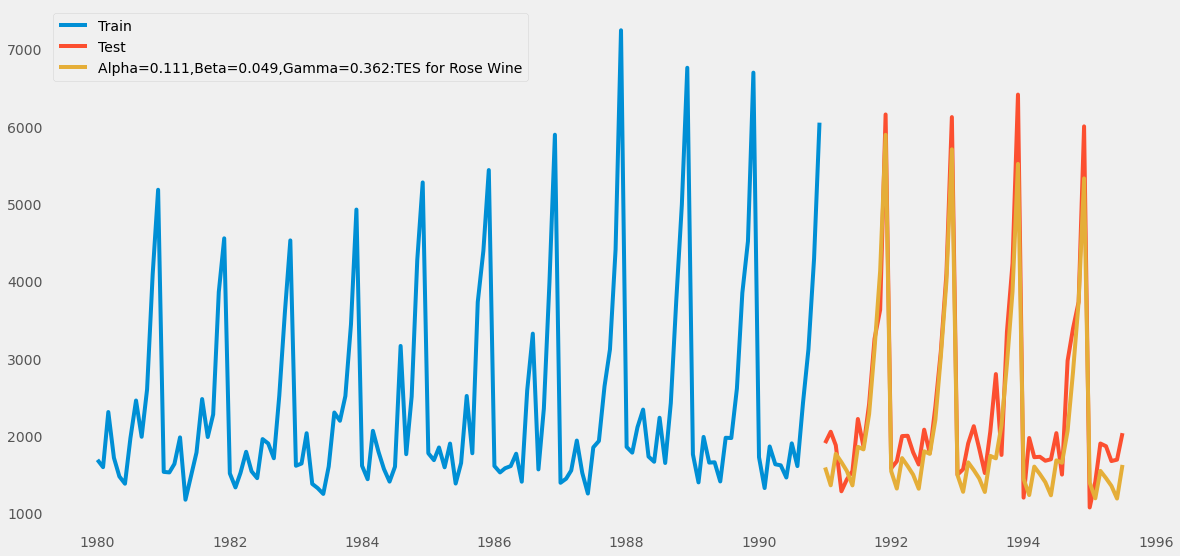

In [377]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(train_sparkling['Sparkling'], label='Train')
plt.plot(test_sparkling['Sparkling'], label='Test')

plt.plot(TES_test_sparkling_am['auto_predict'], label='Alpha=0.111,Beta=0.049,Gamma=0.362:TES for Rose Wine')


plt.legend(loc='best')
plt.grid();

In [379]:
## Test Data

rmse_model6_test_am = rmse(TES_test_sparkling_am['Sparkling'],
                          TES_test_sparkling_am['auto_predict'])
rmse_model6_test_am
print("The RMSE value at Alpha=0.111,Beta=0.049,Gamma=0.362,TES Model is :",rmse_model6_test_am)

The RMSE value at Alpha=0.111,Beta=0.049,Gamma=0.362,TES Model is : 404.3023171296


In [491]:
resultsDf_8_am = pd.DataFrame({'Test RMSE': [rmse_model6_test_am]}
                           ,index=['Alpha=0.111,Beta=0.049,Gamma=0.362,TripleExponentialSmoothing-Sparkling Wine'])
results = pd.concat([results, resultsDf_8_am])
results

Test RMSE
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...  1316.035487
Alpha=0.3,SimpleExponentialSmoothing - Sparklin...  1935.284109
Alpha = 0.664, Beta=0.0001,SimpleExponentialSmo...  5291.879833
Alpha=0.0,Beta=0.4,DoubleExponentialSmoothing-S...  1389.129175
Alpha=0.111,Beta=0.012,Gamma=0.406,TripleExpone...   378.897204
Alpha=0.111,Beta=0.049,Gamma=0.362,TripleExpone...   404.302317

**Inference**

We see that the additive seasonality model has not done that well when compared to the multiplicative seasonality Triple Exponential Smoothing model.



##  Linear Regression Model


### Sparkling Wine data


For this particular linear regression, we are going to regress the 'Sparkling' variable against the order of the occurrence. For this we need to modify our training data before fitting it into a linear regression.

In [94]:
train_time = [i+1 for i in range(len(train_sparkling))] # 1 to 132
test_time = [i+133 for i in range(len(test_sparkling))] # 133 to 187
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
Test Time instance 
 [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


We see that we have successfully the generated the numerical time instance order for both the training and test set. Now we will add these values in the training and test set.

In [95]:
LinearRegression_train_sparkling = train_sparkling.copy()
LinearRegression_test_sparkling = test_sparkling.copy()
LinearRegression_train_sparkling['time'] = train_time
LinearRegression_test_sparkling['time'] = test_time
display(LinearRegression_train_sparkling.head())
display(LinearRegression_test_sparkling.tail())

Sparkling  time
YearMonth                  
1980-01-01       1686     1
1980-02-01       1591     2
1980-03-01       2304     3
1980-04-01       1712     4
1980-05-01       1471     5

Sparkling  time
YearMonth                  
1995-03-01       1897   183
1995-04-01       1862   184
1995-05-01       1670   185
1995-06-01       1688   186
1995-07-01       2031   187

Now that our training and test data has been modified, let us go ahead use Linear Regression to build the model on the training data and test the model on the test data.

In [380]:
from sklearn.linear_model import LinearRegression
lr_sparkling = LinearRegression()
lr_sparkling.fit(LinearRegression_train_sparkling[['time']],LinearRegression_train_sparkling['Sparkling']) 
test_predictions_model1_sparkling= lr_sparkling.predict(LinearRegression_test_sparkling[['time']])
LinearRegression_test_sparkling['RegOnTime'] = test_predictions_model1_sparkling


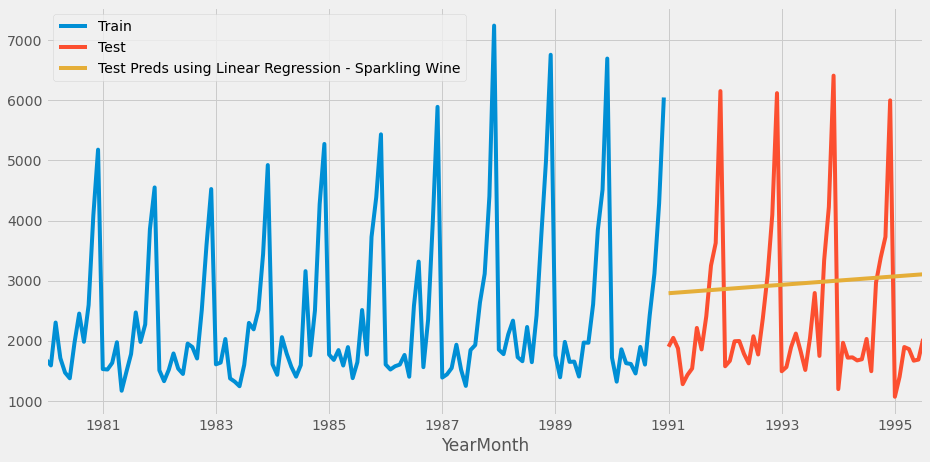

In [381]:
train_sparkling['Sparkling'].plot(legend = True, label = 'Train')
test_sparkling['Sparkling'].plot(legend = True, label = 'Test')
LinearRegression_test_sparkling['RegOnTime'].plot(legend = True, 
                                        label = 'Test Preds using Linear Regression - Sparkling Wine');

In [382]:
from statsmodels.tools.eval_measures import rmse 
rmse_model1_sparkling = rmse(test_sparkling['Sparkling'],test_predictions_model1_sparkling)
print("The RMSE value of Linear Regression Model is :",rmse_model1_sparkling)

The RMSE value of Linear Regression Model is : 1389.135174897992


In [425]:
results_8 = pd.DataFrame({'Test RMSE': rmse_model1_sparkling}
                           ,index=['Linear Regression Model for Sparkling Wine'])

results = pd.concat([results, results_8])
results

Test RMSE
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...   1316.035487
Alpha=0.3,SimpleExponentialSmoothing - Sparklin...   1935.284109
Alpha = 0.664, Beta=0.0001,SimpleExponentialSmo...   5291.879833
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing-S...  18259.110704
Alpha=0.111,Beta=0.012,Gamma=0.406,TripleExpone...    378.897204
Alpha=0.111,Beta=0.049,Gamma=0.362,TripleExpone...    404.302317
Linear Regression Model for Sparkling Wine           1389.135175

**Inference**

* We can see that Linear Regression Model works better compared to DES and TES model.




## Naive Approach Model  $\hat{y}_{t+1} = y_t$


For this particular naive model, we say that the prediction for tomorrow is the same as today and the prediction for day after tomorrow is tomorrow and since the prediction of tomorrow is same as today,therefore the prediction for day after tomorrow is also today.


### Sparkling Wine data

In [383]:
NaiveModel_train_sparkling = train_sparkling.copy()
NaiveModel_test_sparkling = test_sparkling.copy()

In [384]:
NaiveModel_test_sparkling['naive'] = train_sparkling['Sparkling'][len(train_sparkling['Sparkling'])-1] 
# picking out the last value in train dataset

In [385]:
NaiveModel_test_sparkling['naive'].head()

YearMonth
1991-01-01    6047
1991-02-01    6047
1991-03-01    6047
1991-04-01    6047
1991-05-01    6047
Name: naive, dtype: int64

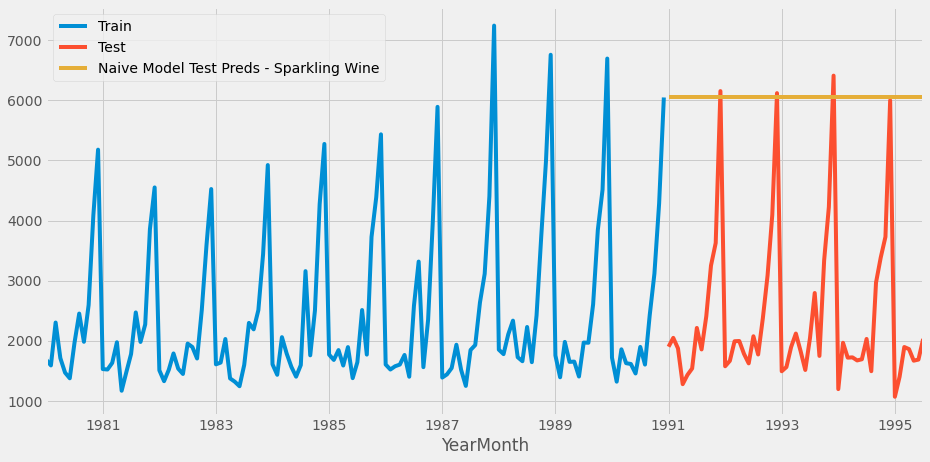

In [386]:
train_sparkling['Sparkling'].plot(legend = True, label = 'Train')
test_sparkling['Sparkling'].plot(legend = True, label = 'Test')
NaiveModel_test_sparkling['naive'].plot(legend = True, label = 'Naive Model Test Preds - Sparkling Wine');

In [387]:
rmse_model_naive_sparkling=rmse(test_sparkling['Sparkling'],NaiveModel_test_sparkling['naive'])
rmse_model_naive_sparkling
print("The RMSE value of Naive Approach Model is :",rmse_model_naive_sparkling)

The RMSE value of Naive Approach Model is : 3864.2793518443914


In [426]:
results_10 = pd.DataFrame({'Test RMSE': rmse_model_naive_sparkling}
                           ,index=['Naive Model for Sparkling Wine'])

results = pd.concat([results, results_10])
results

Test RMSE
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...   1316.035487
Alpha=0.3,SimpleExponentialSmoothing - Sparklin...   1935.284109
Alpha = 0.664, Beta=0.0001,SimpleExponentialSmo...   5291.879833
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing-S...  18259.110704
Alpha=0.111,Beta=0.012,Gamma=0.406,TripleExpone...    378.897204
Alpha=0.111,Beta=0.049,Gamma=0.362,TripleExpone...    404.302317
Linear Regression Model for Sparkling Wine           1389.135175
Naive Model for Sparkling Wine                       3864.279352

## Simple Average Model


For this particular simple average method, we will forecast by using the average of the training values



### Sparkling Wine data

In [389]:
SimpleAverage_train_sparkling = train_sparkling.copy()
SimpleAverage_test_sparkling = test_sparkling.copy()
SimpleAverage_test_sparkling['mean_forecast'] = train_sparkling['Sparkling'].mean()
SimpleAverage_test_sparkling.head()

Sparkling  mean_forecast
YearMonth                           
1991-01-01       1902    2403.780303
1991-02-01       2049    2403.780303
1991-03-01       1874    2403.780303
1991-04-01       1279    2403.780303
1991-05-01       1432    2403.780303

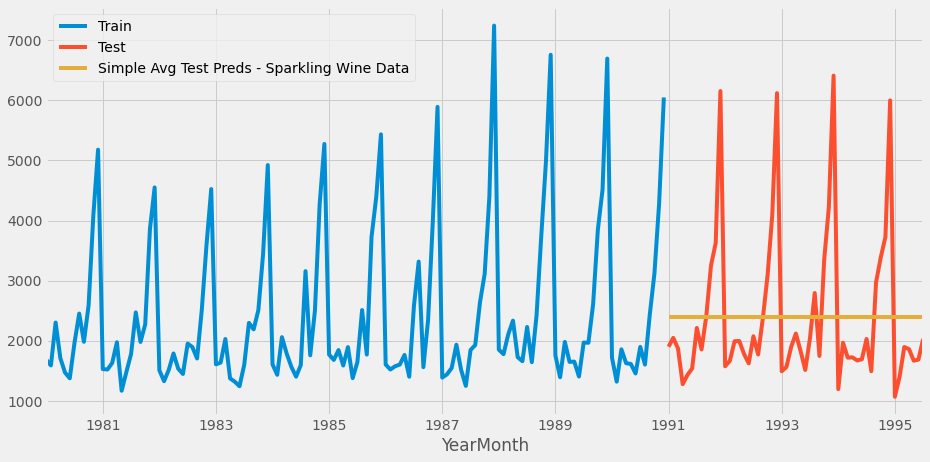

In [390]:
train_sparkling['Sparkling'].plot(legend = True, label = 'Train')
test_sparkling['Sparkling'].plot(legend = True, label = 'Test')
SimpleAverage_test_sparkling['mean_forecast'].plot(legend=True,label= 'Simple Avg Test Preds - Sparkling Wine Data');

In [391]:
## Test Data - RMSE 

rmse_model_sa_sparkling = rmse(test_sparkling['Sparkling'], SimpleAverage_test_sparkling['mean_forecast'])
rmse_model_sa_sparkling
print("The RMSE value of Simple Average Model is :",rmse_model_sa_sparkling)

The RMSE value of Simple Average Model is : 1275.0818036965309


In [427]:
results_12 = pd.DataFrame({'Test RMSE': rmse_model_sa_sparkling}
                           ,index=['Simple Average Model for Sparkling Wine'])

results = pd.concat([results, results_12])
results

Test RMSE
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...   1316.035487
Alpha=0.3,SimpleExponentialSmoothing - Sparklin...   1935.284109
Alpha = 0.664, Beta=0.0001,SimpleExponentialSmo...   5291.879833
Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing-S...  18259.110704
Alpha=0.111,Beta=0.012,Gamma=0.406,TripleExpone...    378.897204
Alpha=0.111,Beta=0.049,Gamma=0.362,TripleExpone...    404.302317
Linear Regression Model for Sparkling Wine           1389.135175
Naive Model for Sparkling Wine                       3864.279352
Simple Average Model for Sparkling Wine              1275.081804

## Moving Average(MA) Model

For the moving average model, we are going to calculate rolling means (or moving averages) for different intervals. The best interval can be determined by the maximum accuracy (or the minimum error) over here.


*For Moving Average, we are going to average over the entire data.*


### Sparkling Wine Data

In [392]:
MovingAverage_sparkling = df_wine_sparkling.copy()
MovingAverage_sparkling.head()

Sparkling
YearMonth            
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471

**Trailing moving averages**

In [393]:
MovingAverage_sparkling['Trailing_2'] = MovingAverage_sparkling['Sparkling'].rolling(2).mean()
MovingAverage_sparkling['Trailing_4'] = MovingAverage_sparkling['Sparkling'].rolling(4).mean()
MovingAverage_sparkling['Trailing_6'] = MovingAverage_sparkling['Sparkling'].rolling(6).mean()
MovingAverage_sparkling['Trailing_9'] = MovingAverage_sparkling['Sparkling'].rolling(9).mean()

MovingAverage_sparkling.head(10)

Sparkling  Trailing_2  Trailing_4   Trailing_6   Trailing_9
YearMonth                                                              
1980-01-01       1686         NaN         NaN          NaN          NaN
1980-02-01       1591      1638.5         NaN          NaN          NaN
1980-03-01       2304      1947.5         NaN          NaN          NaN
1980-04-01       1712      2008.0     1823.25          NaN          NaN
1980-05-01       1471      1591.5     1769.50          NaN          NaN
1980-06-01       1377      1424.0     1716.00  1690.166667          NaN
1980-07-01       1966      1671.5     1631.50  1736.833333          NaN
1980-08-01       2453      2209.5     1816.75  1880.500000          NaN
1980-09-01       1984      2218.5     1945.00  1827.166667  1838.222222
1980-10-01       2596      2290.0     2249.75  1974.500000  1939.333333

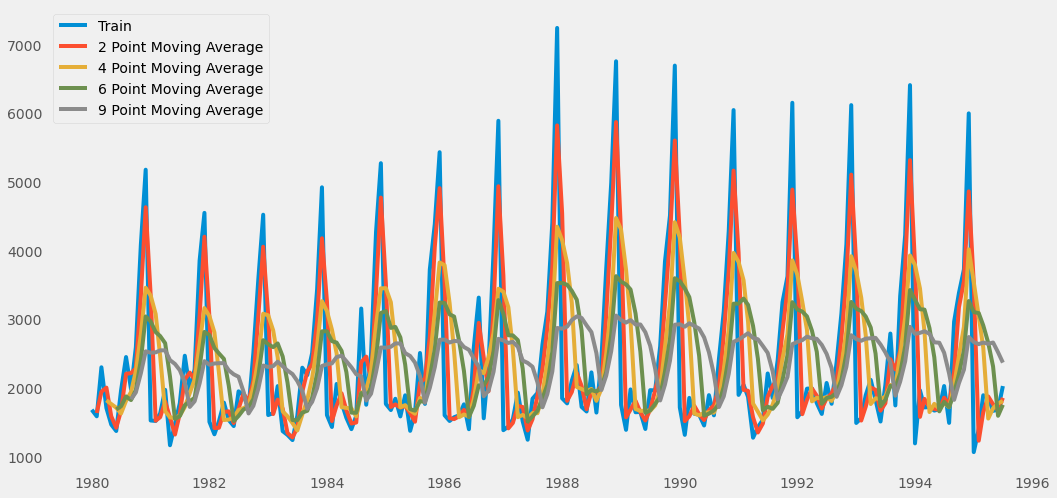

In [394]:
## Plotting on the whole data

plt.figure(figsize=(16,8))
plt.plot(MovingAverage_sparkling['Sparkling'], label='Train')
plt.plot(MovingAverage_sparkling['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage_sparkling['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage_sparkling['Trailing_6'],label = '6 Point Moving Average')
plt.plot(MovingAverage_sparkling['Trailing_9'],label = '9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

**Let us split the data into train and test and plot this Time Series.**

In [113]:
#Creating train and test set 
trailing_MovingAverage_train_sparkling=MovingAverage_sparkling[0:132] 
trailing_MovingAverage_test_sparkling=MovingAverage_sparkling[132:]

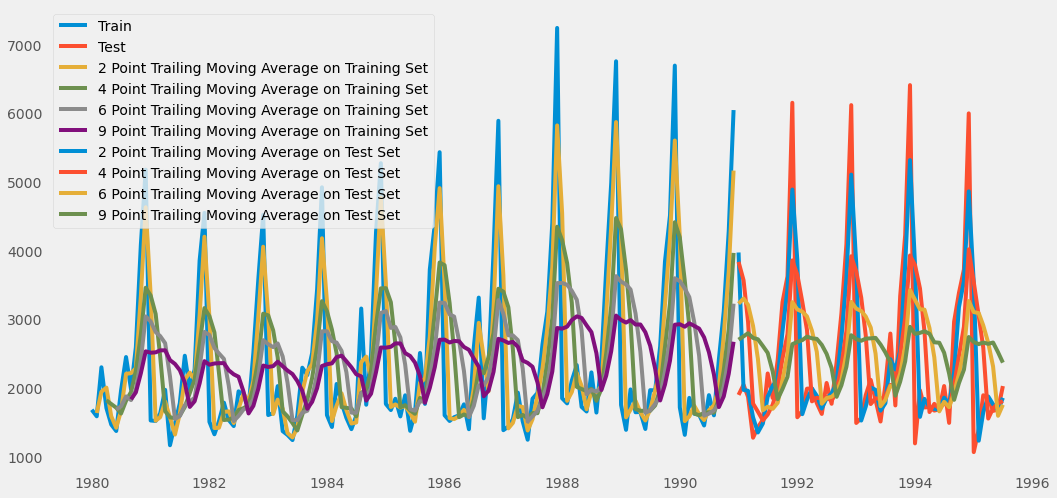

In [395]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(trailing_MovingAverage_train_sparkling['Sparkling'], label='Train')
plt.plot(trailing_MovingAverage_test_sparkling['Sparkling'], label='Test')

plt.plot(trailing_MovingAverage_train_sparkling['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train_sparkling['Trailing_4'], label='4 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train_sparkling['Trailing_6'],label = '6 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train_sparkling['Trailing_9'],label = '9 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test_sparkling['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test_sparkling['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test_sparkling['Trailing_6'],label = '6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test_sparkling['Trailing_9'],label = '9 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid();

**Model Evaluation**

In [428]:
## Test Data - RMSE --> 2 point Trailing MA

rmse_model_ma_spark_test_2 = rmse(test_sparkling['Sparkling'],
                          trailing_MovingAverage_test_sparkling['Trailing_2'])

print("The RMSE value of 2 point Trailing MA Model is :",rmse_model_ma_spark_test_2)

## Test Data - RMSE  --> 4 point Trailing MA

rmse_model_ma_spark_test_4 = rmse(test_sparkling['Sparkling'],trailing_MovingAverage_test_sparkling['Trailing_4'])

print("The RMSE value of 4 point Trailing MA Model is :",rmse_model_ma_spark_test_4)

## Test Data - RMSE --> 6 point Trailing MA

rmse_model_ma_spark_test_6 = rmse(test_sparkling['Sparkling'],trailing_MovingAverage_test_sparkling['Trailing_6'])

print("The RMSE value of 6 point Trailing MA Model is :",rmse_model_ma_spark_test_6)

## Test Data - RMSE  --> 9 point Trailing MA

rmse_model_ma_spark_test_9 = rmse(test_sparkling['Sparkling'],trailing_MovingAverage_test_sparkling['Trailing_9'])

print("The RMSE value of 9 point Trailing MA Model is :",rmse_model_ma_spark_test_9)

The RMSE value of 2 point Trailing MA Model is : 813.4006839972983
The RMSE value of 4 point Trailing MA Model is : 1156.589694081071
The RMSE value of 6 point Trailing MA Model is : 1283.9274280129855
The RMSE value of 9 point Trailing MA Model is : 1346.2783154241804


In [532]:
results_14 = pd.DataFrame({'Test RMSE': [rmse_model_ma_spark_test_2, 
                                          rmse_model_ma_spark_test_4,
                                          rmse_model_ma_spark_test_6, 
                                          rmse_model_ma_spark_test_9]}, 
                           index=['2pointTrailingMovingAverage-Sparkling Wine',
                                  '4pointTrailingMovingAverage-Sparkling Wine', 
                                  '6pointTrailingMovingAverage-Sparkling Wine',
                                  '9pointTrailingMovingAverage-Sparkling Wine'])

results = pd.concat([results, results_14])
results

Test RMSE
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...  1316.035487
Alpha=0.3,SimpleExponentialSmoothing - Sparklin...  1935.284109
Alpha = 0.664, Beta=0.0001,SimpleExponentialSmo...  5291.879833
Alpha=0.0,Beta=0.4,DoubleExponentialSmoothing-S...  1389.129175
Alpha=0.111,Beta=0.012,Gamma=0.406,TripleExpone...   378.897204
Alpha=0.111,Beta=0.049,Gamma=0.362,TripleExpone...   404.302317
SARIMA(3,1,2)(3,1,2,12)                              329.534769
2pointTrailingMovingAverage-Sparkling Wine           813.400684
4pointTrailingMovingAverage-Sparkling Wine          1156.589694
6pointTrailingMovingAverage-Sparkling Wine          1283.927428
9pointTrailingMovingAverage-Sparkling Wine          1346.278315

### 5. Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment. Note: Stationarity should be checked at alpha = 0.05.

**Check for stationarity of the whole Time Series data.**

**Dicky Fuller Test**

* Null Hypothesis H0- Series is not Stationary
* Alternative Hypothesis H1- Series is Stationary

In [117]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller 

### Sparkling Wine data

In [397]:
## Test for stationarity of the series - Dicky Fuller test

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window=7).std()   #determining the rolling standard deviation

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False) ## You plot will stay open - will be seen always
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test for Sparkling Wine Data:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')    


## i) Test for Stationary on whole data

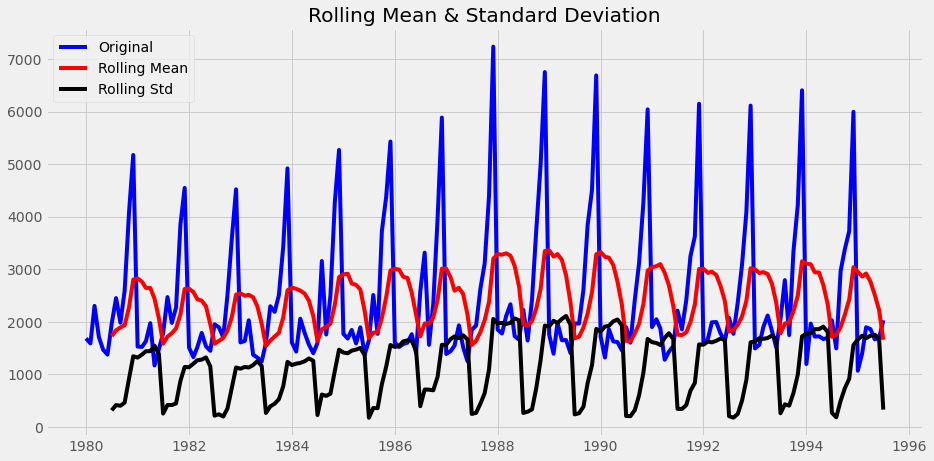

Results of Dickey-Fuller Test for Sparkling Wine Data:
Test Statistic                  -1.360497
p-value                          0.601061
#Lags Used                      11.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64 



In [398]:
test_stationarity(df_wine_sparkling['Sparkling'])

**Inference**

* We can see that the pvalue is greater than 0.05. Thus we cannot reject the Null hypothesis and hence Sparkling Wine data is not stationary.
* We see that at 5% significant level the Time Series is non-stationary.

Let us take a difference of order 1 and check whether the Time Series is stationary or not.

## Taking Difference to make the Data Stationary


### d=1

In [399]:
df_wine_sparkling['Sparkling'].diff()

YearMonth
1980-01-01      NaN
1980-02-01    -95.0
1980-03-01    713.0
1980-04-01   -592.0
1980-05-01   -241.0
              ...  
1995-03-01    495.0
1995-04-01    -35.0
1995-05-01   -192.0
1995-06-01     18.0
1995-07-01    343.0
Name: Sparkling, Length: 187, dtype: float64

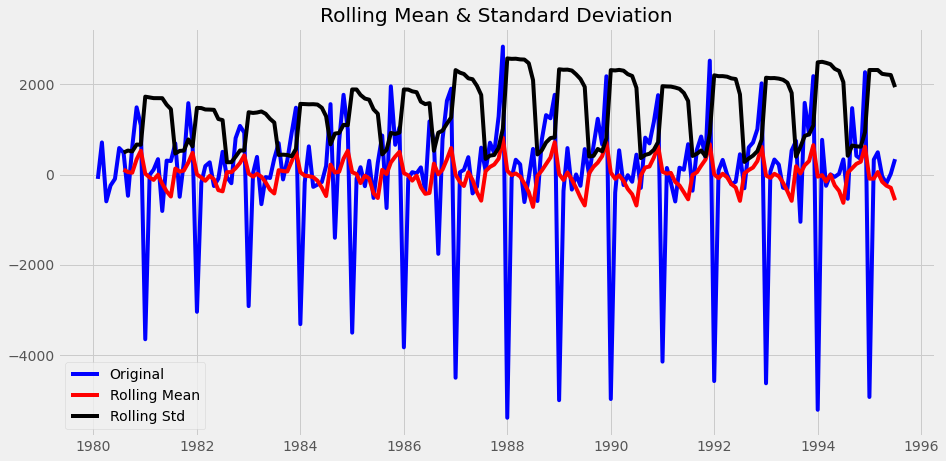

Results of Dickey-Fuller Test for Sparkling Wine Data:
Test Statistic                 -45.050301
p-value                          0.000000
#Lags Used                      10.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64 



In [400]:
test_stationarity(df_wine_sparkling['Sparkling'].diff().dropna())

We see that at  𝛼 = 0.05 the Time Series is indeed stationary as the p-value is lower than 0.05 and hence we can reject the null hypothesis which says that the time series is not stationary. So differentiation by 1 makes the time series stationary.

## ii) Test for Stationary on Train and Test data

In [401]:
adfuller(train_sparkling['Sparkling'])[1]
print("The Dicky Fuller Test value for Train dataset is: ",adfuller(train_sparkling['Sparkling'])[1] )

The Dicky Fuller Test value for Train dataset is:  0.6697444263523343


We see that the series is not stationary at  𝛼  = 0.05. 

In [402]:
adfuller(train_sparkling['Sparkling'].diff().dropna())[1]
print("The Dicky Fuller Test value for Train dataset after differencing (d=1) is: ",adfuller(train_sparkling['Sparkling'].diff().dropna())[1] )

The Dicky Fuller Test value for Train dataset after differencing (d=1) is:  2.2801043558266393e-12


We can see that after taking a difference of order 1 the series have become stationary at  𝛼  = 0.05.

### 6. Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

The data has some seasonality so ideally we should build a SARIMA model. Thus we are are building an ARIMA and SARIMA model with automated versions, by looking at the minimum AIC criterion and manually, by looking at the ACF and the PACF plots

In [125]:
from statsmodels.tsa.arima.model import ARIMA # statsmodels.tsa.arima_model

In [124]:
## The following loop helps us in getting a combination of different parameters of p and q in the range of 0 and 2
## We have kept the value of d as 1 as we already know that we need to take a first order difference of the series to make it stationary.

import itertools # library for generating all possible combinations of given number sets
p = q = range(0, 4)
d= range(1,2) # required as itertools product function expects the parameters as range objects, even if it is only value

pdq = list(itertools.product(p, d, q))

print('Some parameter combinations for the Model...')
for i in range(0,len(pdq)):
    print(f'Model: {pdq[i]}')

Some parameter combinations for the Model...
Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 1, 3)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 1, 3)
Model: (3, 1, 0)
Model: (3, 1, 1)
Model: (3, 1, 2)
Model: (3, 1, 3)


In [126]:
# Creating an empty Dataframe with column names only
ARIMA_AIC_Sparkling = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC_Sparkling

Empty DataFrame
Columns: [param, AIC]
Index: []

In [127]:
for param in pdq:
    ARIMA_model_sparkling = ARIMA(train_sparkling['Sparkling'],
                        order=param).fit()
    
    print(f'ARIMA{param} - AIC:{ARIMA_model_sparkling.aic}')
    
    ARIMA_AIC_Sparkling=ARIMA_AIC_Sparkling.append({'param':param, 
                                'AIC': ARIMA_model_sparkling.aic},
                               ignore_index=True)

ARIMA(0, 1, 0) - AIC:2267.6630357855465
ARIMA(0, 1, 1) - AIC:2263.0600155919765
ARIMA(0, 1, 2) - AIC:2234.4083231278137
ARIMA(0, 1, 3) - AIC:2233.9948577556297
ARIMA(1, 1, 0) - AIC:2266.6085393190097
ARIMA(1, 1, 1) - AIC:2235.75509467511
ARIMA(1, 1, 2) - AIC:2234.5272004514923
ARIMA(1, 1, 3) - AIC:2235.607814177481
ARIMA(2, 1, 0) - AIC:2260.3657439680974
ARIMA(2, 1, 1) - AIC:2233.7776263103638
ARIMA(2, 1, 2) - AIC:2213.5092124421935
ARIMA(2, 1, 3) - AIC:2232.923994058544
ARIMA(3, 1, 0) - AIC:2257.72337899794
ARIMA(3, 1, 1) - AIC:2235.5004106295264
ARIMA(3, 1, 2) - AIC:2231.0554710044607
ARIMA(3, 1, 3) - AIC:2221.454369587561


In [129]:
ARIMA_AIC_Sparkling

param          AIC
0   (0, 1, 0)  2267.663036
1   (0, 1, 1)  2263.060016
2   (0, 1, 2)  2234.408323
3   (0, 1, 3)  2233.994858
4   (1, 1, 0)  2266.608539
5   (1, 1, 1)  2235.755095
6   (1, 1, 2)    2234.5272
7   (1, 1, 3)  2235.607814
8   (2, 1, 0)  2260.365744
9   (2, 1, 1)  2233.777626
10  (2, 1, 2)  2213.509212
11  (2, 1, 3)  2232.923994
12  (3, 1, 0)  2257.723379
13  (3, 1, 1)  2235.500411
14  (3, 1, 2)  2231.055471
15  (3, 1, 3)   2221.45437

In [130]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARIMA_AIC_Sparkling.sort_values(by='AIC',ascending=True)

param          AIC
10  (2, 1, 2)  2213.509212
15  (3, 1, 3)   2221.45437
14  (3, 1, 2)  2231.055471
11  (2, 1, 3)  2232.923994
9   (2, 1, 1)  2233.777626
3   (0, 1, 3)  2233.994858
2   (0, 1, 2)  2234.408323
6   (1, 1, 2)    2234.5272
13  (3, 1, 1)  2235.500411
7   (1, 1, 3)  2235.607814
5   (1, 1, 1)  2235.755095
12  (3, 1, 0)  2257.723379
8   (2, 1, 0)  2260.365744
1   (0, 1, 1)  2263.060016
4   (1, 1, 0)  2266.608539
0   (0, 1, 0)  2267.663036

In [132]:
auto_ARIMA_sparkling = ARIMA(train_sparkling['Sparkling'], order=(2,1,2))

results_auto_ARIMA = auto_ARIMA_sparkling.fit()

results_auto_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Sparkling   No. Observations:                  132
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1101.755
Date:                Fri, 10 Mar 2023   AIC                           2213.509
Time:                        19:03:04   BIC                           2227.885
Sample:                    01-01-1980   HQIC                          2219.351
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3121      0.046     28.782      0.000       1.223       1.401
ar.L2         -0.5593      0.072     -7.740      0.000      -0.701      -0.418
ma.L1         -1.9917      0.109    -18.216      0.000      -2.206      -1.777
ma.L2          0.9999      0.110      9.109      0.000       0.785       1.215
sigma2      1.099e+06   1.99e-07   5.51e+12      0.000     1.1e+06     1.1e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                14.46
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               2.43   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.5e+27. Standard errors may be unstable.
"""

## Predict on the Test Set using this model and evaluate the model.

In [133]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test_sparkling))

In [134]:
predicted_auto_ARIMA

1991-01-01    4252.356430
1991-02-01    2863.097387
1991-03-01    2043.974295
1991-04-01    1746.202326
1991-05-01    1813.625462
1991-06-01    2068.634950
1991-07-01    2365.526034
1991-08-01    2612.453967
1991-09-01    2770.400487
1991-10-01    2839.537788
1991-11-01    2841.914595
1991-12-01    2806.364963
1992-01-01    2758.390578
1992-02-01    2715.325677
1992-03-01    2685.651685
1992-04-01    2670.802187
1992-05-01    2667.914571
1992-06-01    2672.430976
1992-07-01    2679.972032
1992-08-01    2687.340721
1992-09-01    2692.791566
1992-10-01    2695.822394
1992-11-01    2696.750535
1992-12-01    2696.273227
1993-01-01    2695.127839
1993-02-01    2693.891921
1993-03-01    2692.910872
1993-04-01    2692.314871
1993-05-01    2692.081551
1993-06-01    2692.108749
1993-07-01    2692.274932
1993-08-01    2692.477771
1993-09-01    2692.650971
1993-10-01    2692.764783
1993-11-01    2692.817246
1993-12-01    2692.822429
1994-01-01    2692.799886
1994-02-01    2692.767410
1994-03-01  

In [404]:
# from sklearn.metrics import  mean_squared_error --> alternate method
from statsmodels.tools.eval_measures import rmse

# predicted_auto_ARIMA[0] contains the predictions(mean values)
RMSE_autoarima = rmse(test_sparkling['Sparkling'],predicted_auto_ARIMA[0])
#print(RMSE_autoarima)
print("The RMSE value of ARIMA (2,1,2) is:",RMSE_autoarima )

The RMSE value of ARIMA (2,1,2) is: 2249.4895076488106


In [548]:
results_df = pd.DataFrame({'RMSE': [RMSE_autoarima]},
                         index=['ARIMA(2,1,2)'])
results_df

RMSE
ARIMA(2,1,2)  2249.489508

### Automated version of a SARIMA model -Parameter Selection with lowest Akaike Information Criteria (AIC).

Let us look at the ACF plot once more to understand the seasonal parameters PDQ for the SARIMA model.

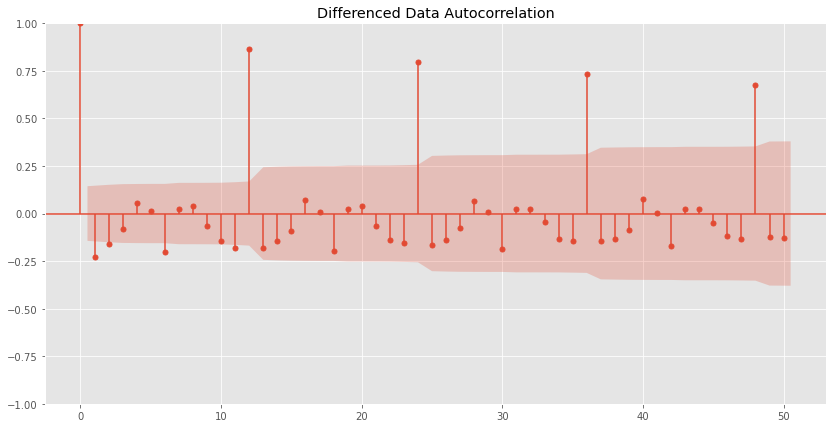

In [138]:
plot_acf(df_wine_sparkling['Sparkling'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation');

We see that there can be a seasonality of 6 as well as 12. We will run our auto SARIMA models by setting seasonality both as 6 and 12.

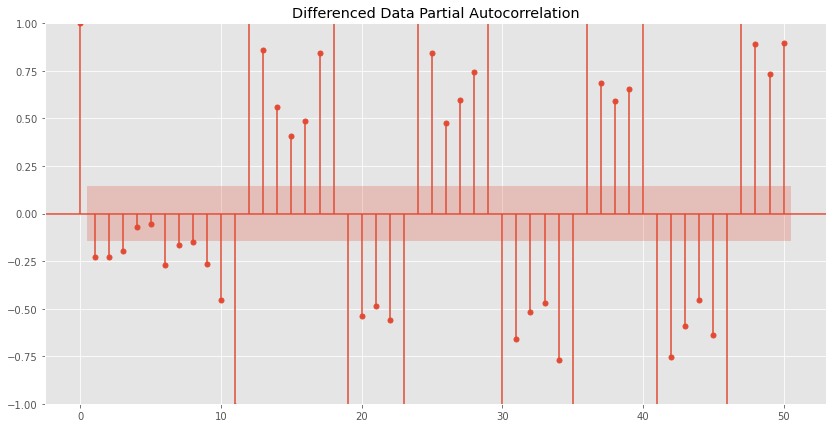

In [139]:
plot_pacf(df_wine_sparkling['Sparkling'].diff().dropna(),lags=50,
          title='Differenced Data Partial Autocorrelation');

We see that there can be a seasonality of 6 as well as 12. We will run our auto SARIMA models by setting seasonality both as 6 and 12.


Here, we have taken alpha=0.05.

 * The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 3.
 * The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 2.


### Auto SARIMA model - With Seasonality as 6

In [234]:
import itertools
p = q = range(0, 4)
d= range(1,2)
D = range(1,2)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, D, q))] # seasonal PDQ
print('Examples of some parameter combinations for Model...')
for i in range(0,len(pdq)):
    print(f'Model: {pdq[i]}{model_pdq[i]}')

Examples of some parameter combinations for Model...
Model: (0, 1, 0)(0, 1, 0, 6)
Model: (0, 1, 1)(0, 1, 1, 6)
Model: (0, 1, 2)(0, 1, 2, 6)
Model: (0, 1, 3)(0, 1, 3, 6)
Model: (1, 1, 0)(1, 1, 0, 6)
Model: (1, 1, 1)(1, 1, 1, 6)
Model: (1, 1, 2)(1, 1, 2, 6)
Model: (1, 1, 3)(1, 1, 3, 6)
Model: (2, 1, 0)(2, 1, 0, 6)
Model: (2, 1, 1)(2, 1, 1, 6)
Model: (2, 1, 2)(2, 1, 2, 6)
Model: (2, 1, 3)(2, 1, 3, 6)
Model: (3, 1, 0)(3, 1, 0, 6)
Model: (3, 1, 1)(3, 1, 1, 6)
Model: (3, 1, 2)(3, 1, 2, 6)
Model: (3, 1, 3)(3, 1, 3, 6)


In [235]:
SARIMA_AIC_1 = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC_1

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [236]:
from  statsmodels.tsa.statespace.sarimax import SARIMAX

# import statsmodels.api as sm
# sm.tsa.statespace.SARIMAX()

In [237]:
for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model_1 = SARIMAX(train_sparkling['Sparkling'],order=param, 
                               seasonal_order = param_seasonal,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
            
        results_SARIMA_1 = SARIMA_model_1.fit(maxiter=1000)
        
        print(f'SARIMA{param}x{param_seasonal} - AIC:{results_SARIMA_1.aic}')
        
        SARIMA_AIC_1 = SARIMA_AIC_1.append({'param':param,
                                        'seasonal':param_seasonal, 
                                        'AIC': results_SARIMA_1.aic},
                                       ignore_index=True)

SARIMA(0, 1, 0)x(0, 1, 0, 6) - AIC:2262.9835238897754
SARIMA(0, 1, 0)x(0, 1, 1, 6) - AIC:2018.7784206921615
SARIMA(0, 1, 0)x(0, 1, 2, 6) - AIC:1859.2938415854717
SARIMA(0, 1, 0)x(0, 1, 3, 6) - AIC:1719.4211330300966
SARIMA(0, 1, 0)x(1, 1, 0, 6) - AIC:1838.4913791966649
SARIMA(0, 1, 0)x(1, 1, 1, 6) - AIC:1825.540475986609
SARIMA(0, 1, 0)x(1, 1, 2, 6) - AIC:1717.6099198654788
SARIMA(0, 1, 0)x(1, 1, 3, 6) - AIC:1633.4524637745496
SARIMA(0, 1, 0)x(2, 1, 0, 6) - AIC:1747.6671722882743
SARIMA(0, 1, 0)x(2, 1, 1, 6) - AIC:1746.2224663333375
SARIMA(0, 1, 0)x(2, 1, 2, 6) - AIC:1719.0962765156287
SARIMA(0, 1, 0)x(2, 1, 3, 6) - AIC:1635.4067565346224
SARIMA(0, 1, 0)x(3, 1, 0, 6) - AIC:1650.1672596141539
SARIMA(0, 1, 0)x(3, 1, 1, 6) - AIC:1649.7725204005055
SARIMA(0, 1, 0)x(3, 1, 2, 6) - AIC:1651.121666866501
SARIMA(0, 1, 0)x(3, 1, 3, 6) - AIC:1639.031259045169
SARIMA(0, 1, 1)x(0, 1, 0, 6) - AIC:2243.355144109237
SARIMA(0, 1, 1)x(0, 1, 1, 6) - AIC:1999.5210480229928
SARIMA(0, 1, 1)x(0, 1, 2, 6) - A

SARIMA(2, 1, 1)x(2, 1, 1, 6) - AIC:1677.3910140688754
SARIMA(2, 1, 1)x(2, 1, 2, 6) - AIC:1658.4733570444507
SARIMA(2, 1, 1)x(2, 1, 3, 6) - AIC:1594.6183498251041
SARIMA(2, 1, 1)x(3, 1, 0, 6) - AIC:1577.792461869675
SARIMA(2, 1, 1)x(3, 1, 1, 6) - AIC:1575.9295043223624
SARIMA(2, 1, 1)x(3, 1, 2, 6) - AIC:1575.1510692438612
SARIMA(2, 1, 1)x(3, 1, 3, 6) - AIC:1577.1468162129722
SARIMA(2, 1, 2)x(0, 1, 0, 6) - AIC:2165.2336560814633
SARIMA(2, 1, 2)x(0, 1, 1, 6) - AIC:1964.477454469421
SARIMA(2, 1, 2)x(0, 1, 2, 6) - AIC:1789.9555875195665
SARIMA(2, 1, 2)x(0, 1, 3, 6) - AIC:1657.7080446432224
SARIMA(2, 1, 2)x(1, 1, 0, 6) - AIC:1758.537353881434
SARIMA(2, 1, 2)x(1, 1, 1, 6) - AIC:1756.3369138964563
SARIMA(2, 1, 2)x(1, 1, 2, 6) - AIC:1642.5145193587296
SARIMA(2, 1, 2)x(1, 1, 3, 6) - AIC:1559.7159671494974
SARIMA(2, 1, 2)x(2, 1, 0, 6) - AIC:1673.6085542890528
SARIMA(2, 1, 2)x(2, 1, 1, 6) - AIC:1676.858082932215
SARIMA(2, 1, 2)x(2, 1, 2, 6) - AIC:1646.1694871491145
SARIMA(2, 1, 2)x(2, 1, 3, 6) - A

In [238]:
SARIMA_AIC_1.sort_values(by=['AIC']).head()

param      seasonal          AIC
55   (0, 1, 3)  (1, 1, 3, 6)  1543.957103
183  (2, 1, 3)  (1, 1, 3, 6)  1545.674351
119  (1, 1, 3)  (1, 1, 3, 6)  1545.898909
59   (0, 1, 3)  (2, 1, 3, 6)  1545.914969
123  (1, 1, 3)  (2, 1, 3, 6)  1546.962155

In [239]:
# Now build a SARIMA model using the pdq and PDQ values identified above
auto_SARIMA_1 =SARIMAX(train_sparkling['Sparkling'].values,
                                order=(0, 1, 3),
                                seasonal_order=(1, 1, 3, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_auto_SARIMA_1 = auto_SARIMA_1.fit(maxiter=1000)
results_auto_SARIMA_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  132
Model:             SARIMAX(0, 1, 3)x(1, 1, 3, 6)   Log Likelihood                -763.979
Date:                           Fri, 10 Mar 2023   AIC                           1543.957
Time:                                   23:14:23   BIC                           1565.035
Sample:                                        0   HQIC                          1552.494
                                           - 132                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7666      0.104     -7.385      0.000      -0.970      -0.563
ma.L2         -0.2804      0.159     -1.759      0.079      -0.593       0.032
ma.L3          0.1950      0.123      1.583      0.114      -0.046       0.436
ar.S.L6       -1.0245      0.008   -132.414      0.000      -1.040      -1.009
ma.S.L6        0.0354      0.159      0.222      0.824      -0.277       0.347
ma.S.L12      -0.5564      0.097     -5.766      0.000      -0.746      -0.367
ma.S.L18       0.1282      0.159      0.806      0.421      -0.184       0.440
sigma2      1.586e+05   1.97e+04      8.061      0.000     1.2e+05    1.97e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                21.16
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.45
Prob(H) (two-sided):                  0.49   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

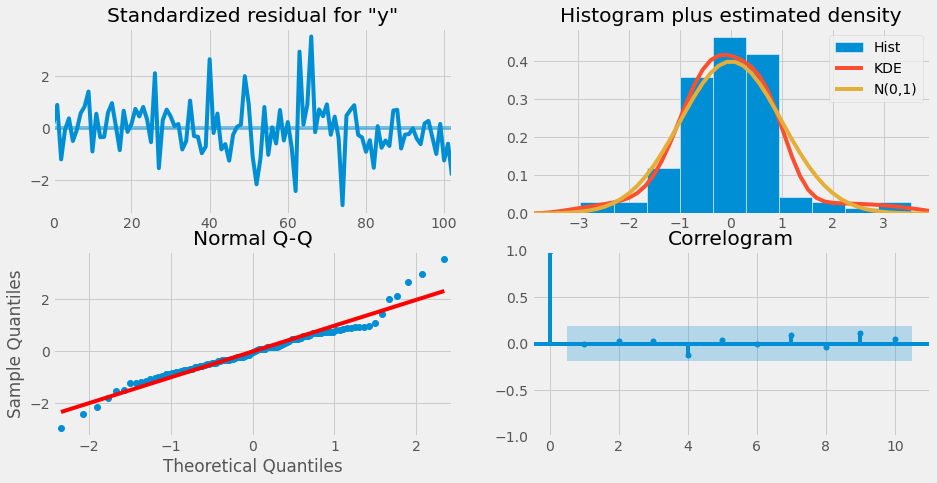

In [405]:
results_auto_SARIMA_1.plot_diagnostics()
plt.show()

From the model diagnostics plot, we can see that all the individual diagnostics plots almost follow the theoretical numbers and thus we cannot develop any pattern from these plots.

### Prediction on the Test Set & Evaluation

In [241]:
predicted_auto_SARIMA_1 = results_auto_SARIMA_1.get_forecast(steps=len(test_sparkling))


In [242]:
predicted_auto_SARIMA_1

In [243]:
predicted_auto_SARIMA_1.predicted_mean

array([1371.5484722 , 1093.16075784, 1643.87819793, 1465.72273951,
       1170.97143952,  915.01724197, 1681.8706916 , 1565.82001878,
       2126.95071421, 3079.52258284, 4298.46511669, 6338.68045407,
       1200.61309038,  792.06041824, 1476.2445276 , 1211.2025594 ,
        885.43141048,  523.08302422, 1501.59135881, 1412.82366923,
       1952.87454799, 2935.24128804, 4191.98278915, 6290.98858624,
       1003.24931433,  586.87154021, 1274.58257326,  979.01665654,
        614.52160395,  191.94416216, 1323.78685945, 1243.0357512 ,
       1779.47340286, 2793.11100895, 4089.52398322, 6250.23263396,
        805.40692501,  380.81640474, 1072.22908014,  744.62710286,
        339.48982069, -146.30033652, 1146.47268497, 1074.13528783,
       1606.78071837, 2653.23830377, 3991.28801833, 6216.7561924 ,
        607.06221262,  173.85209869,  869.14979042,  507.9247327 ,
         60.13186397, -492.00247472,  969.67312535])

In [244]:
predicted_auto_SARIMA_1.summary_frame(alpha=0.05).head()

y         mean     mean_se  mean_ci_lower  mean_ci_upper
0  1371.548472  398.368878     590.759818    2152.337126
1  1093.160758  409.081404     291.375939    1894.945577
2  1643.878198  409.506502     841.260203    2446.496192
3  1465.722740  413.702633     654.880479    2276.565000
4  1170.971440  417.880378     351.940948    1990.001931

In [245]:
from statsmodels.tools.eval_measures import rmse

In [406]:
rmse_autosarima6 =rmse(test_sparkling['Sparkling'],predicted_auto_SARIMA_1.predicted_mean)
display(rmse_autosarima6)     
print("The RMSE value of SARIMA(0,1,3)(1,1,3,6) Model is:",rmse_autosarima6 )

877.7698840952028

The RMSE value of SARIMA(0,1,3)(1,1,3,6) Model is: 877.7698840952028


In [549]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse_sarimax]}
                           ,index=['SARIMA(0,1,3)(1,1,3,6)'])


results_df = pd.concat([results_df,temp_resultsDf])

results_df

RMSE
ARIMA(2,1,2)            2249.489508
SARIMA(0,1,3)(1,1,3,6)   878.159915

### Setting the seasonality as 12 for the second iteration of the auto SARIMA model.

In [226]:
import itertools
p = q = range(0, 3)
d= range(1,2)
D = range(1,2)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of some parameter combinations for Model...')
for i in range(1,len(pdq)):
    print(f'Model: {pdq[i]}{model_pdq[i]}')

Examples of some parameter combinations for Model...
Model: (0, 1, 1)(0, 1, 1, 12)
Model: (0, 1, 2)(0, 1, 2, 12)
Model: (1, 1, 0)(1, 1, 0, 12)
Model: (1, 1, 1)(1, 1, 1, 12)
Model: (1, 1, 2)(1, 1, 2, 12)
Model: (2, 1, 0)(2, 1, 0, 12)
Model: (2, 1, 1)(2, 1, 1, 12)
Model: (2, 1, 2)(2, 1, 2, 12)


In [227]:
SARIMA_AIC_2 = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC_2

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [228]:

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model_2 =SARIMAX(train_sparkling['Sparkling'],
                                            order=param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA_2 = SARIMA_model_2.fit(maxiter=1000)
        
        print(f'SARIMA{param}x{param_seasonal} - AIC:{results_SARIMA_2.aic}')
        
        SARIMA_AIC_2 = SARIMA_AIC_2.append({'param':param,
                                        'seasonal':param_seasonal ,
                                        'AIC': results_SARIMA_2.aic},
                                       ignore_index=True)

SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:1822.982485206384
SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:1626.8626334678302
SARIMA(0, 1, 0)x(0, 1, 2, 12) - AIC:1452.6773574253307
SARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:1646.3778167661442
SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:1628.3243908183626
SARIMA(0, 1, 0)x(1, 1, 2, 12) - AIC:1454.528962130665
SARIMA(0, 1, 0)x(2, 1, 0, 12) - AIC:1466.6211360755017
SARIMA(0, 1, 0)x(2, 1, 1, 12) - AIC:1468.5000981866674
SARIMA(0, 1, 0)x(2, 1, 2, 12) - AIC:1455.9911553671218
SARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:1760.6565719828463
SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:1569.6639234230086
SARIMA(0, 1, 1)x(0, 1, 2, 12) - AIC:1399.1083846680071
SARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:1602.859481902383
SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:1570.8550259196138
SARIMA(0, 1, 1)x(1, 1, 2, 12) - AIC:1400.6709524137261
SARIMA(0, 1, 1)x(2, 1, 0, 12) - AIC:1428.244881123038
SARIMA(0, 1, 1)x(2, 1, 1, 12) - AIC:1429.6168027963845
SARIMA(0, 1, 1)x(2, 1, 2, 12) - AIC:1402.6385888521502
SARIMA(0, 1, 2

In [229]:
SARIMA_AIC_2.sort_values(by=['AIC']).head()

param       seasonal          AIC
47  (1, 1, 2)  (0, 1, 2, 12)   1382.34778
20  (0, 1, 2)  (0, 1, 2, 12)  1382.484254
50  (1, 1, 2)  (1, 1, 2, 12)  1384.137874
74  (2, 1, 2)  (0, 1, 2, 12)  1384.317618
23  (0, 1, 2)  (1, 1, 2, 12)  1384.398867

In [221]:

auto_SARIMA_2 =SARIMAX(train_sparkling['Sparkling'],
                                order=(1, 1, 2),
                                seasonal_order=(0, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_auto_SARIMA_2 = auto_SARIMA_2.fit(maxiter=1000)

results_auto_SARIMA_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Sparkling   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -685.174
Date:                            Fri, 10 Mar 2023   AIC                           1382.348
Time:                                    22:53:43   BIC                           1397.479
Sample:                                01-01-1980   HQIC                          1388.455
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5507      0.287     -1.922      0.055      -1.112       0.011
ma.L1         -0.1612      0.235     -0.687      0.492      -0.621       0.299
ma.L2         -0.7218      0.175     -4.132      0.000      -1.064      -0.379
ma.S.L12      -0.4062      0.092     -4.401      0.000      -0.587      -0.225
ma.S.L24      -0.0274      0.138     -0.198      0.843      -0.298       0.243
sigma2      1.705e+05   2.45e+04      6.956      0.000    1.22e+05    2.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.48
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.60
Prob(H) (two-sided):                  0.75   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

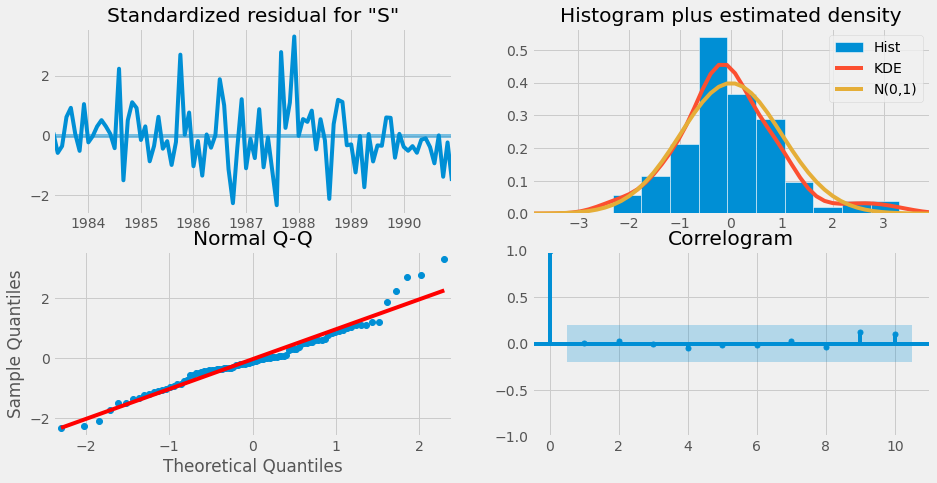

In [407]:
results_auto_SARIMA_2.plot_diagnostics()
plt.show()

### Predict on the Test Set & Evaluation

In [230]:
predicted_auto_SARIMA_2 = results_auto_SARIMA_2.get_forecast(steps=len(test_sparkling))

In [409]:
predicted_auto_SARIMA_2.predicted_mean

1991-01-01    1460.244623
1991-02-01    1392.437145
1991-03-01    1743.201689
1991-04-01    1650.066910
1991-05-01    1522.656012
1991-06-01    1365.342180
1991-07-01    1854.399113
1991-08-01    1664.797805
1991-09-01    2343.554282
1991-10-01    3223.021964
1991-11-01    4306.225027
1991-12-01    6199.418117
1992-01-01    1469.490786
1992-02-01    1302.529246
1992-03-01    1707.870355
1992-04-01    1586.390627
1992-05-01    1472.250622
1992-06-01    1303.705870
1992-07-01    1801.976068
1992-08-01    1616.355636
1992-09-01    2288.019603
1992-10-01    3179.400581
1992-11-01    4256.180855
1992-12-01    6158.415571
1993-01-01    1418.870705
1993-02-01    1244.817142
1993-03-01    1654.063641
1993-04-01    1530.433318
1993-05-01    1417.477588
1993-06-01    1248.280687
1993-07-01    1746.910007
1993-08-01    1561.091816
1993-09-01    2232.864683
1993-10-01    3124.185693
1993-11-01    4200.998990
1993-12-01    6103.215520
1994-01-01    1363.680669
1994-02-01    1189.621591
1994-03-01  

In [231]:
predicted_auto_SARIMA_2.summary_frame(alpha=0.05).head()

Sparkling          mean     mean_se  mean_ci_lower  mean_ci_upper
1991-01-01  1460.244623  412.922811     650.930784    2269.558462
1991-02-01  1392.437145  429.721344     550.198787    2234.675502
1991-03-01  1743.201689  430.065909     900.287996    2586.115382
1991-04-01  1650.066910  433.930071     799.579599    2500.554221
1991-05-01  1522.656012  434.242958     671.555454    2373.756570

In [411]:
rmse_autosarima12 = rmse(test_sparkling['Sparkling'],
                         predicted_auto_SARIMA_2.predicted_mean)
#print(rmse_autosarima12)
print("The RMSE value of SARIMA(1,1,2)(0,1,2,12) Model is:",rmse_autosarima12 )

The RMSE value of SARIMA(1,1,2)(0,1,2,12) Model is: 382.5767445220656


In [550]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse_autosarima12]}
                           ,index=['SARIMA(1,1,2)(0,1,2,12)'])


results_df = pd.concat([results_df,temp_resultsDf])

results_df

RMSE
ARIMA(2,1,2)             2249.489508
SARIMA(0,1,3)(1,1,3,6)    878.159915
SARIMA(1,1,2)(0,1,2,12)   382.576745

### 7. Build ARIMA/SARIMA models based on the cut-off points of ACF and PACF on the training data and evaluate this model on the test data using RMSE.

### Manual ARIMA model - Using ACF & PACF plots

Let us look at the ACF and the PACF plots once more.

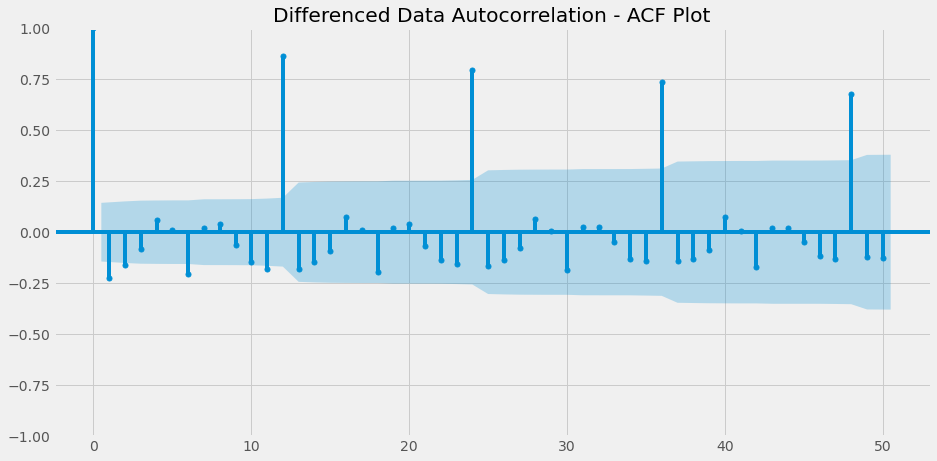

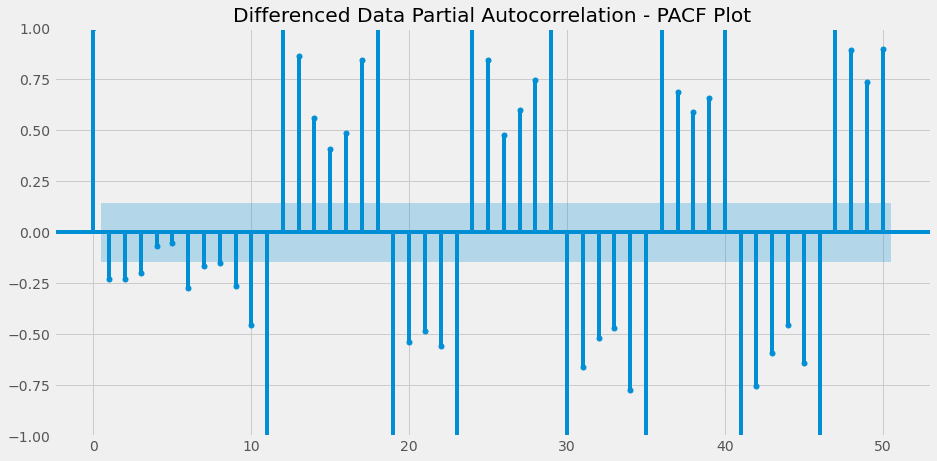

In [414]:
plot_acf(df_wine_sparkling['Sparkling'].diff().dropna(),
         lags=50,
         title='Differenced Data Autocorrelation - ACF Plot');
plot_pacf(df_wine_sparkling['Sparkling'].diff().dropna(),
          lags=50,
          title='Differenced Data Partial Autocorrelation - PACF Plot');

Here, we have taken alpha=0.05.

* The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 3.
* The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 2.

By looking at the above plots, we can say that both the PACF and ACF plot cuts-off at lag 3 & 2. So,our pdq values are 3,1,2.
By looking at the above plots, we can say that both the PACF and ACF plot cuts-off at lag 3 & 2. P=3 and Q = 2

In [256]:
manual_ARIMA = ARIMA(train_sparkling['Sparkling'].astype('float64'), order=(3,1,2))

results_manual_ARIMA = manual_ARIMA.fit()

print(results_manual_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  132
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1109.528
Date:                Fri, 10 Mar 2023   AIC                           2231.055
Time:                        23:31:31   BIC                           2248.307
Sample:                    01-01-1980   HQIC                          2238.065
                         - 12-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4559      0.027    -16.601      0.000      -0.510      -0.402
ar.L2          0.3014      0.128      2.358      0.018       0.051       0.552
ar.L3         -0.2427      0.100     -2.417      0.0

We get a comparatively simpler model by looking at the ACF and the PACF plots.

We can see that both the AR(p) and the MA(q) model are of order 3 & 2, we have to convert the input variable into a 'float64' type variable else Python might throw an error when we try to forecast

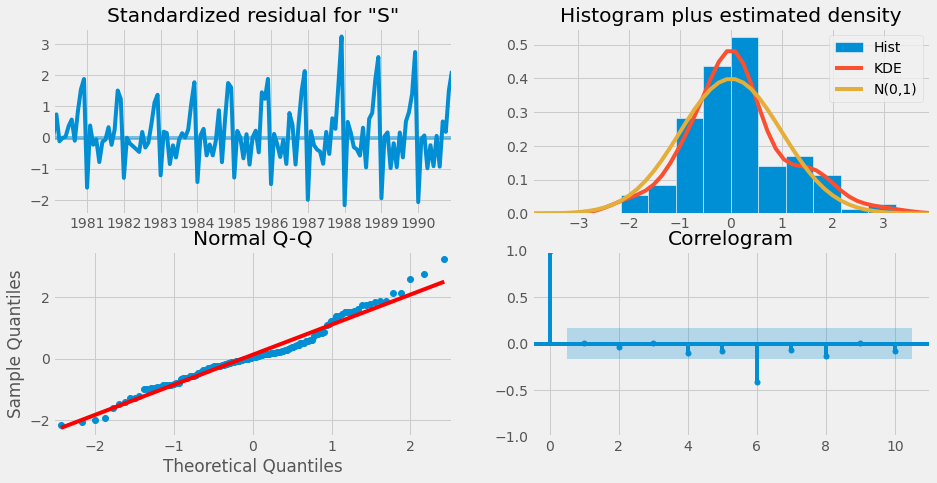

In [415]:
results_manual_ARIMA.plot_diagnostics()
plt.show()

### Predict on the Test Set & Evaluation

In [257]:
predicted_manual_ARIMA = results_manual_ARIMA.forecast(steps=len(test_sparkling))

In [418]:
from statsmodels.tools.eval_measures import rmse
RMSE_manualarima = rmse(test_sparkling['Sparkling'],
                        predicted_manual_ARIMA)
RMSE_manualarima
print("The RMSE value of ARIMA (3,1,2) is:",RMSE_manualarima )


The RMSE value of ARIMA (3,1,2) is: 1287.929617583484


In [551]:
temp_resultsDf = pd.DataFrame({'RMSE': [RMSE_manualarima]}
                           ,index=['ARIMA(3,1,2) Manual'])


results_df = pd.concat([results_df,temp_resultsDf])

results_df

RMSE
ARIMA(2,1,2)             2249.489508
SARIMA(0,1,3)(1,1,3,6)    878.159915
SARIMA(1,1,2)(0,1,2,12)   382.576745
ARIMA(3,1,2) Manual      1287.929618

### **Manual SARIMA MODEL**

Here, we have taken alpha=0.05.

* The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 3.
* The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 2.

By looking at the above plots, we can say that both the PACF and ACF plot cuts-off at lag 3 & 2. So,our pdq values are 3,1,2.
By looking at the above plots, we can say that both the PACF and ACF plot cuts-off at lag 0 & 3. P=3 and Q =2. 
D = 1 (difference order) and F=12 (Seasonality)

In [518]:
manual_sarima = SARIMAX(train_sparkling['Sparkling'],
                                order=(3,1,2),
                                seasonal_order=(3, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_manual_sarima = manual_sarima.fit(maxiter=1000)
results_manual_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Sparkling   No. Observations:                  132
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -598.630
Date:                            Sun, 12 Mar 2023   AIC                           1219.260
Time:                                    20:40:27   BIC                           1245.462
Sample:                                01-01-1980   HQIC                          1229.765
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7556      0.151     -5.013      0.000      -1.051      -0.460
ar.L2          0.1169      0.185      0.633      0.527      -0.245       0.479
ar.L3         -0.0520      0.143     -0.365      0.715      -0.332       0.228
ma.L1          0.0330      0.191      0.173      0.863      -0.341       0.407
ma.L2         -0.9670      0.156     -6.197      0.000      -1.273      -0.661
ar.S.L12      -0.7538      0.496     -1.520      0.128      -1.725       0.218
ar.S.L24      -0.6371      0.351     -1.818      0.069      -1.324       0.050
ar.S.L36      -0.2469      0.151     -1.641      0.101      -0.542       0.048
ma.S.L12       0.3719      0.491      0.758      0.448      -0.590       1.334
ma.S.L24       0.3466      0.365      0.949      0.343      -0.370       1.063
sigma2       1.79e+05   1.67e-06   1.07e+11      0.000    1.79e+05    1.79e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                13.16
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.62
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.84e+27. Standard errors may be unstable.
"""

In [519]:
print("The AIC value for full data SARIMAX (3,1,2) (3,1,2,12) is :" , results_manual_sarima.aic)

The AIC value for full data SARIMAX (0,1,2) (2,1,2,12) is : 1219.2599786456226


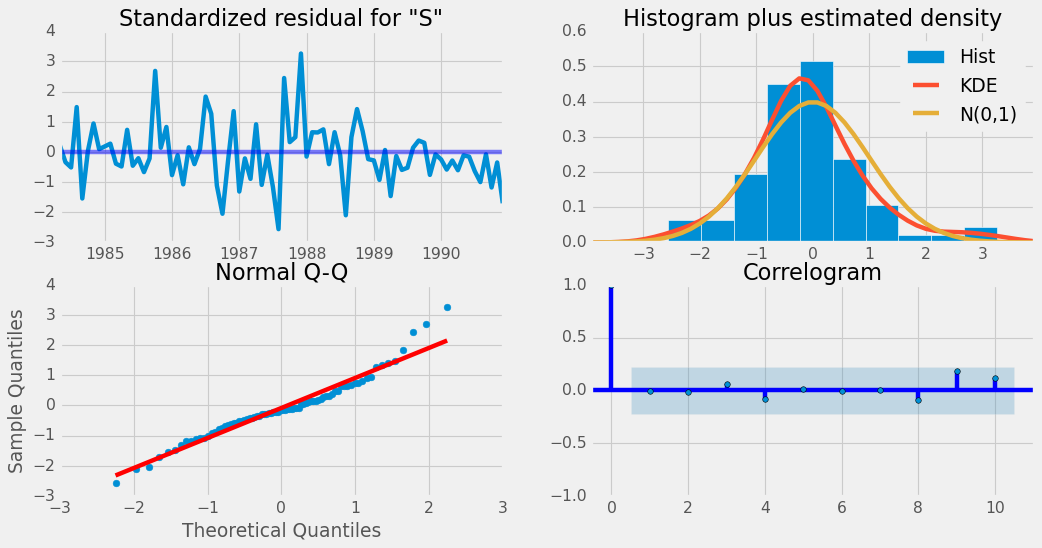

In [521]:
results_manual_sarima.plot_diagnostics()
plt.show()

**Predict on the Test Set & Evaluation**

In [522]:
predicted_manual_sarima= results_manual_sarima.get_forecast(steps=len(test_sparkling))
predicted_manual_sarima.summary_frame(alpha=0.05).head()

Sparkling          mean     mean_se  mean_ci_lower  mean_ci_upper
1991-01-01  1510.232757  425.098487     677.055034    2343.410481
1991-02-01  1431.675559  440.080543     569.133545    2294.217573
1991-03-01  1850.402600  440.152336     987.719875    2713.085326
1991-04-01  1781.972603  440.897547     917.829291    2646.115915
1991-05-01  1550.445066  440.887747     686.320961    2414.569171

In [523]:
predicted_manual_sarima.predicted_mean

1991-01-01    1510.232757
1991-02-01    1431.675559
1991-03-01    1850.402600
1991-04-01    1781.972603
1991-05-01    1550.445066
1991-06-01    1468.969868
1991-07-01    1830.989719
1991-08-01    1657.694641
1991-09-01    2515.372293
1991-10-01    3396.900708
1991-11-01    4412.698669
1991-12-01    6447.415998
1992-01-01    1603.699090
1992-02-01    1460.638925
1992-03-01    1883.764145
1992-04-01    1801.779767
1992-05-01    1578.893407
1992-06-01    1508.033615
1992-07-01    1866.744530
1992-08-01    1635.056326
1992-09-01    2443.814885
1992-10-01    3477.680230
1992-11-01    4451.184143
1992-12-01    6334.618479
1993-01-01    1569.868282
1993-02-01    1406.013467
1993-03-01    1840.308449
1993-04-01    1703.639205
1993-05-01    1554.422024
1993-06-01    1463.640896
1993-07-01    1850.851172
1993-08-01    1710.119796
1993-09-01    2438.093845
1993-10-01    3416.791115
1993-11-01    4353.667848
1993-12-01    6320.628494
1994-01-01    1545.997736
1994-02-01    1395.430808
1994-03-01  

In [558]:
rmse_sarima = rmse(test_sparkling['Sparkling'],
                         predicted_manual_sarima.predicted_mean)

print("The RMSE value of Manual SARIMA(3,1,2)(3,1,2,12) Model is:",rmse_sarima )

The RMSE value of Manual SARIMA(3,1,2)(3,1,2,12) Model is: 329.5347690867294


In [552]:
temp_results = pd.DataFrame({'RMSE': [rmse_sarima]}
                           ,index=['SARIMA(3,1,2)(3,1,2,12) Manual'])


results_df = pd.concat([results_df,temp_results])

results_df

RMSE
ARIMA(2,1,2)                    2249.489508
SARIMA(0,1,3)(1,1,3,6)           878.159915
SARIMA(1,1,2)(0,1,2,12)          382.576745
ARIMA(3,1,2) Manual             1287.929618
SARIMA(3,1,2)(3,1,2,12) Manual   329.534769

We can see that RMSE value of SARIMA (3,1,2) (3,1,2,12) Model is Best compared to ARIMA model and other SARIMA models

### 8. Build a table (create a data frame) with all the models built along with their corresponding parameters and the respective RMSE values on the test data.

In [542]:
results

Test RMSE
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...  1316.035487
Alpha=0.3,SimpleExponentialSmoothing - Sparklin...  1935.284109
Alpha = 0.664, Beta=0.0001,SimpleExponentialSmo...  5291.879833
Alpha=0.0,Beta=0.4,DoubleExponentialSmoothing-S...  1389.129175
Alpha=0.111,Beta=0.012,Gamma=0.406,TripleExpone...   378.897204
Alpha=0.111,Beta=0.049,Gamma=0.362,TripleExpone...   404.302317
2pointTrailingMovingAverage-Sparkling Wine           813.400684
4pointTrailingMovingAverage-Sparkling Wine          1156.589694
6pointTrailingMovingAverage-Sparkling Wine          1283.927428
9pointTrailingMovingAverage-Sparkling Wine          1346.278315

In [553]:
results_df

RMSE
ARIMA(2,1,2)                    2249.489508
SARIMA(0,1,3)(1,1,3,6)           878.159915
SARIMA(1,1,2)(0,1,2,12)          382.576745
ARIMA(3,1,2) Manual             1287.929618
SARIMA(3,1,2)(3,1,2,12) Manual   329.534769

In [554]:
results_df.rename (columns = {'RMSE' : 'Test RMSE'},inplace = True)

In [555]:
results_total = pd.concat([results,results_df])

In [556]:
results_total

Test RMSE
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...  1316.035487
Alpha=0.3,SimpleExponentialSmoothing - Sparklin...  1935.284109
Alpha = 0.664, Beta=0.0001,SimpleExponentialSmo...  5291.879833
Alpha=0.0,Beta=0.4,DoubleExponentialSmoothing-S...  1389.129175
Alpha=0.111,Beta=0.012,Gamma=0.406,TripleExpone...   378.897204
Alpha=0.111,Beta=0.049,Gamma=0.362,TripleExpone...   404.302317
2pointTrailingMovingAverage-Sparkling Wine           813.400684
4pointTrailingMovingAverage-Sparkling Wine          1156.589694
6pointTrailingMovingAverage-Sparkling Wine          1283.927428
9pointTrailingMovingAverage-Sparkling Wine          1346.278315
ARIMA(2,1,2)                                        2249.489508
SARIMA(0,1,3)(1,1,3,6)                               878.159915
SARIMA(1,1,2)(0,1,2,12)                              382.576745
ARIMA(3,1,2) Manual                                 1287.929618
SARIMA(3,1,2)(3,1,2,12) Manual                       329.534769

In [557]:
results_total.sort_values(by='Test RMSE')

Test RMSE
SARIMA(3,1,2)(3,1,2,12) Manual                       329.534769
Alpha=0.111,Beta=0.012,Gamma=0.406,TripleExpone...   378.897204
SARIMA(1,1,2)(0,1,2,12)                              382.576745
Alpha=0.111,Beta=0.049,Gamma=0.362,TripleExpone...   404.302317
2pointTrailingMovingAverage-Sparkling Wine           813.400684
SARIMA(0,1,3)(1,1,3,6)                               878.159915
4pointTrailingMovingAverage-Sparkling Wine          1156.589694
6pointTrailingMovingAverage-Sparkling Wine          1283.927428
ARIMA(3,1,2) Manual                                 1287.929618
Alpha=0.049,SimpleExponentialSmoothing-Sparklin...  1316.035487
9pointTrailingMovingAverage-Sparkling Wine          1346.278315
Alpha=0.0,Beta=0.4,DoubleExponentialSmoothing-S...  1389.129175
Alpha=0.3,SimpleExponentialSmoothing - Sparklin...  1935.284109
ARIMA(2,1,2)                                        2249.489508
Alpha = 0.664, Beta=0.0001,SimpleExponentialSmo...  5291.879833

We can see that RMSE value of SARIMA (3,1,2) (3,1,2,12) Model is Best compared to ARIMA model and other SARIMA models

### 9. Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.

**Building the most optimum model on the Full Data**

## MODEL - 1 TRIPLE EXPONENTIAL SMOOTHING  

In [508]:
fullmodel1 = ExponentialSmoothing(df_wine_sparkling,
                                  trend='additive',
                                  seasonal='multiplicative').fit(smoothing_level=0.111,
                                                                 smoothing_trend=0.012,
                                                                 smoothing_seasonal=0.406)

In [512]:
RMSE_fullmodel1 = rmse(df_wine_sparkling['Sparkling'],fullmodel1.fittedvalues)

RMSE_fullmodel1
print("The RMSE value of TES Model on Full Dataset with Alpha = 0.111,Beta = 0.012,Gamma = 0.406 is:",RMSE_fullmodel1)

The RMSE value of TES Model on Full Dataset with Alpha = 0.111,Beta = 0.012,Gamma = 0.406 is: 354.2470498550359


In [511]:
fullmodel1.fittedvalues

YearMonth
1980-01-01    1786.186635
1980-02-01    1695.273419
1980-03-01    2148.569764
1980-04-01    1947.567613
1980-05-01    1594.402342
                 ...     
1995-03-01    1754.544656
1995-04-01    1769.568065
1995-05-01    1650.312013
1995-06-01    1545.492977
1995-07-01    1990.993849
Length: 187, dtype: float64

In [502]:
# Getting the predictions for the same number of times stamps that are present in the test data
prediction_1 = fullmodel1.forecast(steps=12)

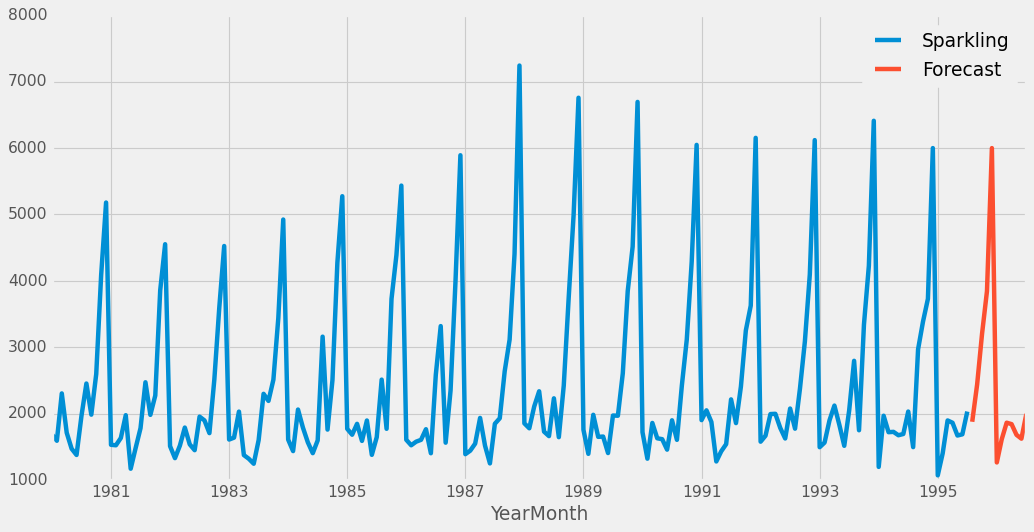

In [503]:
df_wine_sparkling.plot(legend  = True, label = 'Actual')
prediction_1.plot(legend = True, label = 'Forecast');

### Prediction Confidence Intervals : Margin of Error


One assumption that we have made over here while calculating the confidence bands is that the standard deviation of the forecast distribution is almost equal to the residual standard deviation.

In [504]:
#In the below code, we have calculated the upper and lower confidence bands at 95% confidence level.Here we are taking the multiplier to be 1.96 since in a normal distribution( as the residual should be if you have done the modelling properly,), 95% of values lie within +/- 1.96 sigma of the mean

pred_1_df = pd.DataFrame({'lower_CI':prediction_1 - 1.96*fullmodel1.resid.std(),
                          'prediction':prediction_1,
                          'upper_ci': prediction_1 + 1.96*fullmodel1.resid.std()}).round(0)
pred_1_df.head()

lower_CI  prediction  upper_ci
1995-08-01    1181.0      1877.0    2573.0
1995-09-01    1743.0      2439.0    3135.0
1995-10-01    2506.0      3202.0    3898.0
1995-11-01    3148.0      3844.0    4540.0
1995-12-01    5303.0      5999.0    6695.0

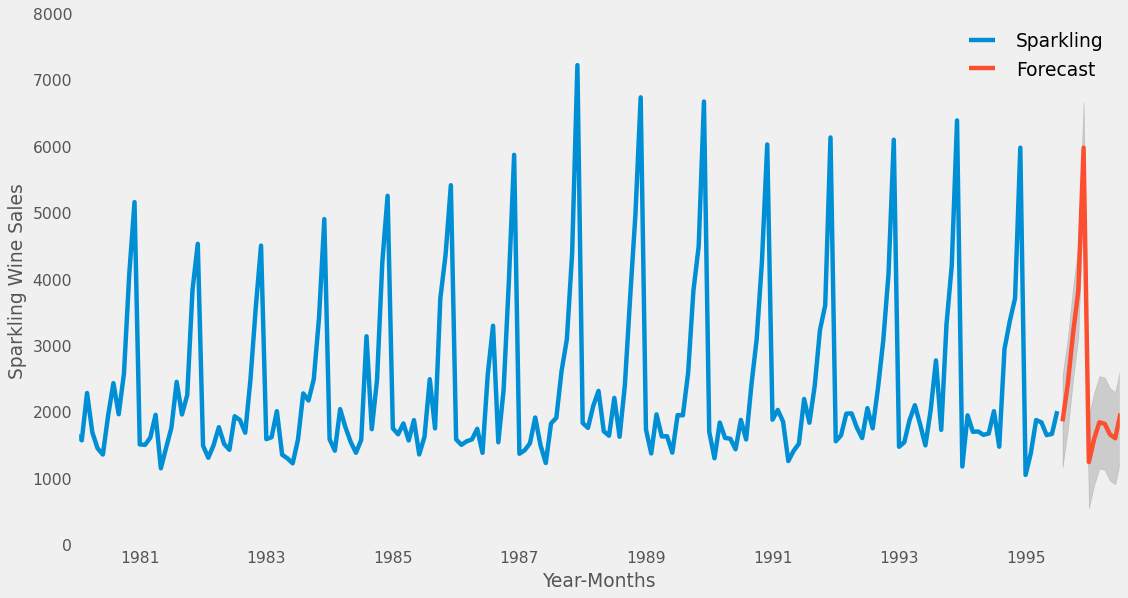

In [505]:
# plot the forecast along with the confidence band

axis = df_wine_sparkling.plot(label='Actual', figsize=(15,8)) # saving the plot axis to refer to it later for superimposing other plots or add layers to it

pred_1_df['prediction'].plot(ax=axis, label='Forecast', alpha=1) # alpha here is for transparency of the prediction line

# fill_between function shades a specified region in the plot. The region's bounds are specified as the x axis values and y axis values

axis.fill_between(pred_1_df.index, 
                  pred_1_df['lower_CI'], 
                  pred_1_df['upper_ci'], 
                  color='Black', 
                  alpha=.15) # alpha here denotes the transparency of the shaded region

axis.set_xlabel('Year-Months')
axis.set_ylabel('Sparkling Wine Sales')
plt.legend(loc='best')
plt.grid();

**Inference**

•	From the above plot the TES Model with “multiplicative” seasonality is performing well.

•	We can see that the future 12 months of Rose Wine sales are fluctuating with seasonal variations.


### SARIMAX Model on Full Data

In [559]:
full_data_model = SARIMAX(df_wine_sparkling['Sparkling'],
                                order=(3,1,2),
                                seasonal_order=(3, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_full_data_model = full_data_model.fit(maxiter=1000)
results_full_data_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Sparkling   No. Observations:                  187
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood               -1000.243
Date:                            Sun, 12 Mar 2023   AIC                           2022.487
Time:                                    21:07:19   BIC                           2054.445
Sample:                                01-01-1980   HQIC                          2035.473
                                     - 07-01-1995                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8610      0.090     -9.546      0.000      -1.038      -0.684
ar.L2          0.0119      0.129      0.092      0.927      -0.241       0.265
ar.L3         -0.0766      0.102     -0.753      0.451      -0.276       0.123
ma.L1          0.0323      0.120      0.269      0.788      -0.203       0.267
ma.L2         -0.9678      0.098     -9.839      0.000      -1.161      -0.775
ar.S.L12      -0.6107      0.392     -1.557      0.119      -1.379       0.158
ar.S.L24      -0.4985      0.231     -2.162      0.031      -0.950      -0.047
ar.S.L36      -0.2473      0.109     -2.264      0.024      -0.461      -0.033
ma.S.L12       0.1234      0.395      0.312      0.755      -0.651       0.898
ma.S.L24       0.2491      0.266      0.937      0.349      -0.272       0.770
sigma2      1.562e+05   1.31e-06   1.19e+11      0.000    1.56e+05    1.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                26.95
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.59
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.05e+27. Standard errors may be unstable.
"""

In [567]:
results_full_data_model.aic
print("The AIC value for full data SARIMAX (3,1,2) (3,1,2,12) is :" , results_full_data_model.aic)

The AIC value for full data SARIMAX (3,1,2) (3,1,2,12) is : 2022.4865969429143


### Evaluating the model on the whole and predicting 12 months into the future 

In [561]:
predicted_manual_SARIMA_6_full_data = results_full_data_model.get_forecast(steps=12)

In [569]:
predicted_manual_SARIMA_6_full_data.summary_frame(alpha=0.05).head()

Sparkling          mean     mean_se  mean_ci_lower  mean_ci_upper
1995-08-01  1868.821792  396.483464    1091.728481    2645.915102
1995-09-01  2511.264155  401.837683    1723.676769    3298.851540
1995-10-01  3272.720105  402.681420    2483.479024    4061.961186
1995-11-01  3874.493688  403.096971    3084.438142    4664.549234
1995-12-01  6099.031103  403.116610    5308.937066    6889.125141

In [563]:
rmse_full_data = rmse(df_wine_sparkling['Sparkling'],results_full_data_model.fittedvalues)
rmse_full_data

print("The RMSE value of SARIMA (3,1,2) (3,1,2,12) Model on Full Sparkling Wine Dataset is:",rmse_full_data )


The RMSE value of SARIMA (3,1,2) (3,1,2,12) Model on Full Sparkling Wine Dataset is: 578.9658090162529


The above RMSE is on the training data predictions only. We cannot calculate RMSE for forecast as the actual values(which have not occured yet) are not available for it to be compared with the forecasted value.

In [564]:
pred_full_manual_SARIMA_data = predicted_manual_SARIMA_6_full_data.summary_frame(alpha=0.05).set_index(pd.date_range(start='1995-08-01',end='1996-07-31', freq='M'))

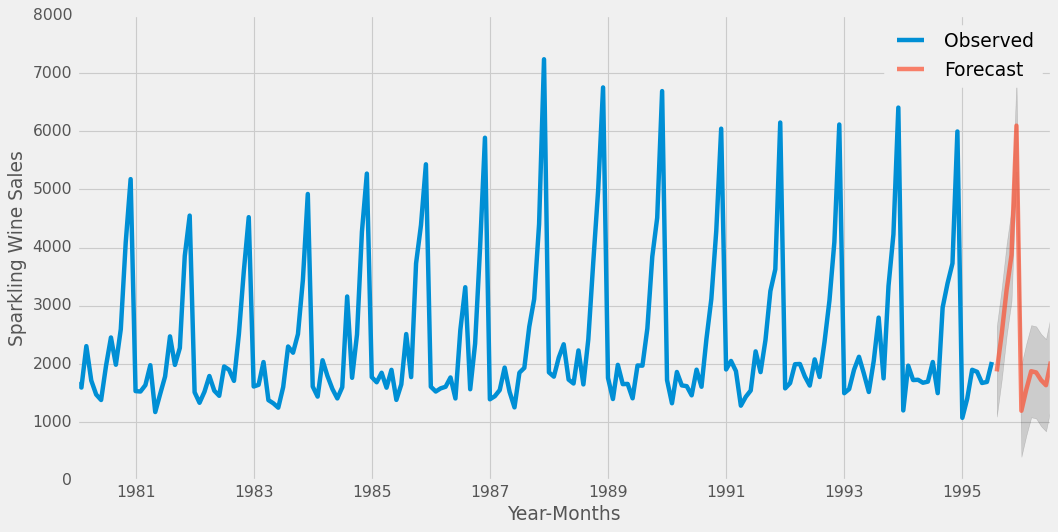

In [565]:
# plot the forecast along with the confidence band

axis = df_wine_sparkling['Sparkling'].plot(label='Observed')

pred_full_manual_SARIMA_data['mean'].plot(ax=axis, label='Forecast', alpha=0.7)

axis.fill_between(pred_full_manual_SARIMA_data.index, 
                  pred_full_manual_SARIMA_data['mean_ci_lower'], 
                  pred_full_manual_SARIMA_data['mean_ci_upper'], 
                  color='black', alpha=.15)

axis.set_xlabel('Year-Months')
axis.set_ylabel('Sparkling Wine Sales')
plt.legend(loc='best')
plt.show()

**Inference**



### 10. Comment on the model thus built and report your findings and suggest the measures that the company should be taking for future sales.
Please explain and summarise the various steps performed in this project. There should be proper business interpretation and actionable insights present.

Given in Report